In [11]:
import matplotlib.pyplot as plt
from climatereconstructionai import evaluate
import os
import regex as re
from dat_to_nc import DatToNcConverter
import pandas as pd
from tqdm import tqdm

In [12]:
station_name = "Marshall"
model_name_note = "minutely"
test_year = 2021
at_iterations = "final"
has_no_time_context = False

In [13]:
def evaluate_wrapper(use_time_context = True, iter = "final", station = station_name, reconstruct_gaps=False):

    snapshot_folder_name = f"snapshots_{station.lower()}"

    # copy "test_args_template.txt" to "test_args_temp.txt"
    # while replacing:

    replace_dir = {
        "STATIONNAME" : station.lower() if not reconstruct_gaps else f"the_gaps_{station.lower()}",
        "ITERATION" : str(iter),
        "SNAPSHOTDIR" : snapshot_folder_name,
        "_NOTE": f"_{model_name_note}" if model_name_note else ""
    }
    
    if reconstruct_gaps:
        replace_dir["_leading_trailing"] = ""
        replace_dir["cleaned_"] = "cleaned_era5_for_"
    

    template_file = "test_args_template_trailing.txt" if use_time_context else "test_args_template_no-time.txt"
    temp_file = "test_args_temp.txt"


    with open(template_file, "r") as f:
        lines = f.readlines()
        with open(temp_file, "w") as f2:
            for line in lines:
                for key in replace_dir:
                    line = re.sub(key, replace_dir[key], line)
                f2.write(line)
                
            # save and close
            f2.close()

    evaluate(temp_file)

    os.remove(temp_file)

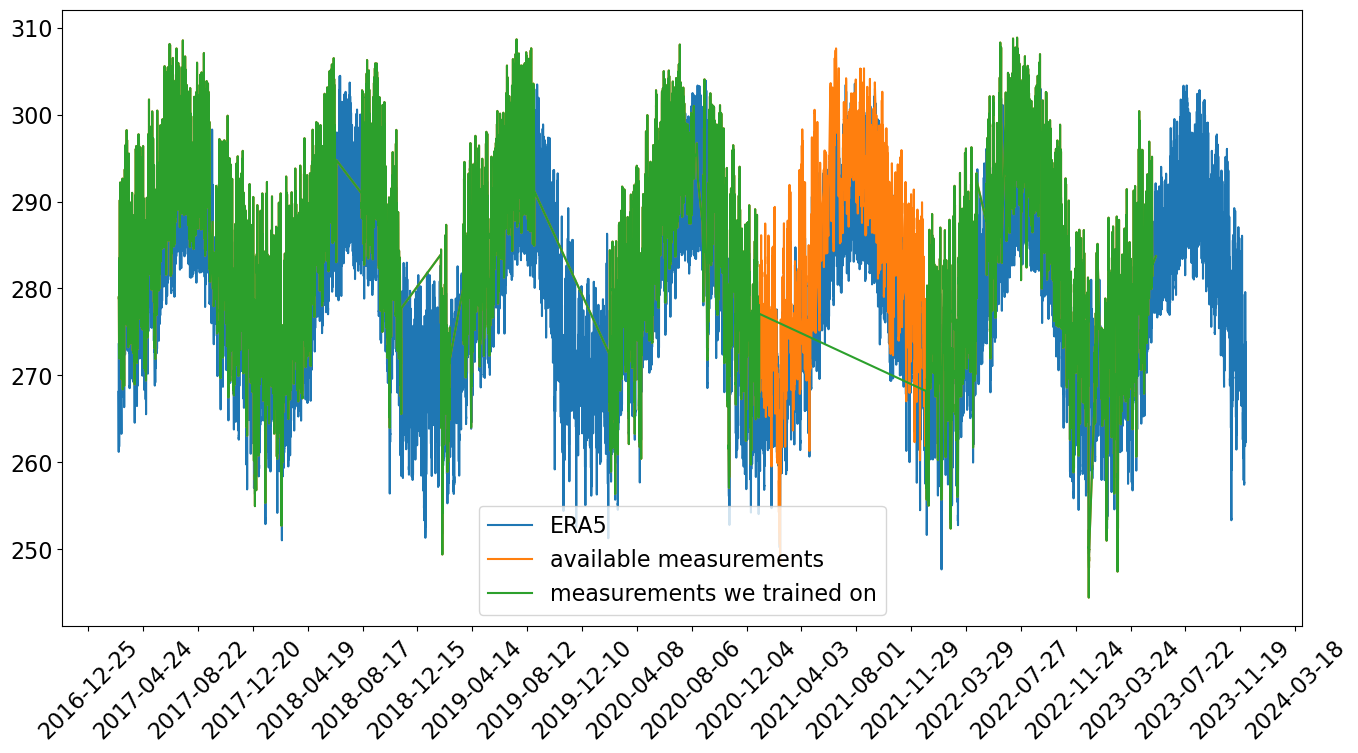

In [14]:
import xarray as xr
from utils import DataSet, DatasetPlotter
import numpy as np
import os

test_folder_path = "/work/bm1159/XCES/xces-work/k203179/data/test"
train_folder_path = "/work/bm1159/XCES/xces-work/k203179/data/train"
output_file_path = "outputs/output_output.nc"
era5_file = test_folder_path + f"/era5_for_{station_name.lower()}_leading_trailing.nc"
era5_full_file = f"/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_{station_name.lower()}.nc"
era5_gaps_file = f"/work/bm1159/XCES/xces-work/k203179/data_sets/era5_gaps_for_{station_name.lower()}.nc"

# get measurements values

measurements_data = xr.open_dataset(test_folder_path + f"/{station_name.lower()}.nc")
era5_data = xr.open_dataset(era5_file)
measurements_data_trained = xr.open_dataset(train_folder_path + f"/expected_{station_name.lower()}.nc")

era5_full_data = xr.open_dataset(era5_full_file)

plt.plot(era5_full_data["time"], era5_full_data["tas"].mean(axis=(1,2)), label = "ERA5")
plt.plot(measurements_data["time"], measurements_data["tas"].mean(axis=(1,2)), label = "available measurements")
plt.plot(measurements_data_trained["time"], measurements_data_trained["tas"].mean(axis=(1,2)), label = "measurements we trained on")
plt.legend()

# rotate x-axis labels, and show them every 6 months
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(120))

# figure size A4 landscape
plt.gcf().set_size_inches(16, 8)
plt.show()


## Evaluate with no timecontext

In [15]:
output_no_time_data = None
evaluate_wrapper(use_time_context = False, iter = at_iterations, station = station_name)
output_no_time_ds = DataSet(output_file_path, name = "Reconstructed")
output_no_time_data = xr.open_dataset(output_file_path)

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


RuntimeError: Error(s) in loading state_dict for CRAINet:
	size mismatch for encoder.0.partial_conv.input_conv.weight: copying a param with shape torch.Size([18, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([18, 1, 7, 7]).
	size mismatch for encoder.0.partial_conv.mask_conv.weight: copying a param with shape torch.Size([18, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([18, 1, 7, 7]).
	size mismatch for decoder.2.partial_conv.input_conv.weight: copying a param with shape torch.Size([1, 21, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 19, 3, 3]).
	size mismatch for decoder.2.partial_conv.mask_conv.weight: copying a param with shape torch.Size([1, 21, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 19, 3, 3]).

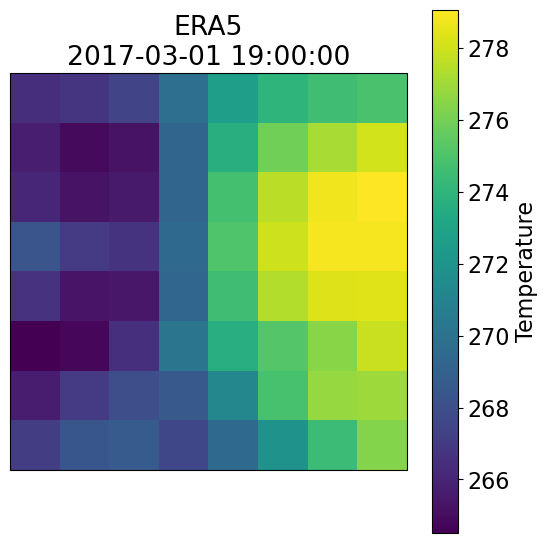

[38.92270253 39.20373283 39.48476313 39.76579343 40.04682373 40.32785403
 40.60888433 40.88991463]
[-106.3125  -106.03125 -105.75    -105.46875 -105.1875  -104.90625
 -104.625   -104.34375]


NameError: name 'output_no_time_ds' is not defined

In [ ]:
era5_ds = DataSet(era5_file, name = "ERA5")
plotter1 = DatasetPlotter(era5_ds)
plotter1.plot()
print(era5_ds.lat)
print(era5_ds.lon - 360)
plotter2 = DatasetPlotter(output_no_time_ds)
plotter2.time_index_list = plotter1.time_index_list
plotter2.plot()

## Evaluate with time contex

In [ ]:
if has_no_time_context:
    output_with_time_data = output_no_time_data
else:
    evaluate_wrapper(use_time_context = True, iter = at_iterations, station = station_name)
    output_with_time_ds = DataSet(output_file_path, name="Reconstructed with time context")
    output_with_time_data = xr.open_dataset(output_file_path)

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1/1 [00:27<00:00, 27.69s/it]


In [16]:
# get coordinates from measurements nc file
import numpy as np

converter_to_get_metadata = DatToNcConverter(station_name)
station_lon, station_lat = converter_to_get_metadata.meta_data.get("longitude"), converter_to_get_metadata.meta_data.get("latitude")
print(f"station is at {station_lon}, {station_lat}")

# get nearest coordinates in era5
def get_left_right_nearest_elem_in_sorted_array(array, value):
    length = len(array)
    left = len(list(filter(lambda x: x <= value, array))) - 1
    right = length - len(list(filter(lambda x: x >= value, array)))
    nearest = min(left, right, key=lambda x: abs(array[x] - value))
    return left, right, nearest

test_array = [1, 2, 3, 4, 5, 6, 7, 8]
test_search = 5.51

print(f"searching for {test_search} in {test_array}")
left_idx, right_idx, nearest_idx =  get_left_right_nearest_elem_in_sorted_array(test_array, test_search)
print(f"idx left to {test_search} is {left_idx}, idx right to {test_search} is {right_idx}, nearest idx is {nearest_idx}")
print(f"mid crop: {test_array[left_idx:right_idx+1]}")


station is at -105.196, 39.9496
searching for 5.51 in [1, 2, 3, 4, 5, 6, 7, 8]
idx left to 5.51 is 4, idx right to 5.51 is 5, nearest idx is 5
mid crop: [5, 6]


In [97]:
def era_vs_reconstructed_comparision_to_df(era5_data, reconstructed_with_time_data, reconstructed_no_time_data, measurements_data):

    lon_left_idx, lon_right_idx, lon_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    lat_left_idx, lat_right_idx, lat_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat)

    era5_nearest_values = era5_data.variables["tas"][:, lon_nearest_idx, lat_nearest_idx]
    
    reconstructed_with_time_data_values = reconstructed_with_time_data.variables["tas"].stack(grid=['lat', 'lon']).values
    if reconstructed_no_time_data is not None:
        reconstructed_no_time_data_values = reconstructed_no_time_data.variables["tas"].stack(grid=['lat', 'lon']).values
    
    measurements_data_values = measurements_data.variables["tas"][...].mean(axis=(1,2))
    

    # timeaxis 
    time = era5_data.variables["time"][:]

    # create dataframe with all values
    df = pd.DataFrame()

    df["time"] = time

    # index should be time
    df.set_index("time", inplace=True)

    df["era5_nearest"] = era5_nearest_values
    if reconstructed_no_time_data is not None:
        df["reconstructed_median"] = [np.median(x) for x in reconstructed_no_time_data_values]
    df["reconstructed_with_time_context_median"] = [np.median(x) for x in reconstructed_with_time_data_values]
    df["measurements"] = measurements_data_values

    return df


def era_vs_reconstructed_comparision_to_minutely_df(era5_data, reconstructed_with_time_data, reconstructed_no_time_data, measurements_data):
    lon_left_idx, lon_right_idx, lon_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    lat_left_idx, lat_right_idx, lat_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat)

    era5_nearest_values = era5_data.variables["tas"][:, lon_nearest_idx, lat_nearest_idx]

    dfs_per_hour = []
    # for timestep in era5
    # add all the available minutely data from measurements and reconsturction using the map_minutes_to_grid funct.
    
    for hour_index, hour in tqdm(enumerate(era5_data.variables["time"][:].values), total=len(era5_data.variables["time"][:])):
        # interpolate from this hour to the next 60 minutes
        era5_minutely = np.linspace(era5_nearest_values[hour_index], (era5_nearest_values[hour_index+1] if hour_index + 1 < len(era5_nearest_values) else era5_nearest_values[hour_index]), 60)
        from map_minutes_to_grid import mapping_rule
        # array length 60 None s
        measr_minutely = [None] * 60
        reconstr_minutely = [None] * 60
        reconstr_with_time_minutely = [None] * 60
        for minute in range(60):
            _lat_idx, _lon_idx = mapping_rule[minute]
            measr_minutely[minute] = measurements_data.variables["tas"][hour_index, _lon_idx, _lat_idx].values
            measr_minutely[minute] = None if np.isnan(measr_minutely[minute]) else measr_minutely[minute]
            if reconstructed_no_time_data is not None:
                reconstr_minutely[minute] = reconstructed_no_time_data.variables["tas"][hour_index, _lon_idx, _lat_idx].values
                reconstr_minutely[minute] = None if np.isnan(reconstr_minutely[minute]) else reconstr_minutely[minute]
            if reconstructed_with_time_data is not None:
                reconstr_with_time_minutely[minute] = reconstructed_with_time_data.variables["tas"][hour_index, _lon_idx, _lat_idx].values
                reconstr_with_time_minutely[minute] = None if np.isnan(reconstr_with_time_minutely[minute]) else reconstr_with_time_minutely[minute]
        minutely_timestamps = [hour + pd.Timedelta(minutes=i) for i in range(60)]
        # append hour to df
        local_df = pd.DataFrame({
            "time": list(minutely_timestamps),
            "era5_nearest": list(era5_minutely),
            "measurements": list(measr_minutely),
            "reconstructed_median": list(reconstr_minutely),
            "reconstructed_with_time_context_median": list(reconstr_with_time_minutely)
        })
        dfs_per_hour.append(local_df)
        
    df = pd.concat(dfs_per_hour)
    
    
    # index should be time
    df.set_index("time", inplace=True)
    
    
    return df

    

# Generate Dataframe
- makes resampling easier

In [98]:
minutely_df = era_vs_reconstructed_comparision_to_minutely_df(era5_data, output_with_time_data, output_no_time_data, measurements_data)

  0%|          | 0/32956 [00:00<?, ?it/s]

100%|██████████| 32956/32956 [11:34<00:00, 47.47it/s]  


In [99]:
# drop where measurements are nan
minutely_df["measurements"] = pd.to_numeric(minutely_df["measurements"], errors="coerce")
minutely_df = minutely_df.dropna(subset=["measurements"])
minutely_df

era5_nearest        measurements reconstructed_median  \
time                                                                         
2017-03-01 19:00:00    275.036621  278.04999999999995                 None   
2017-03-01 19:01:00    275.061587              278.25                 None   
2017-03-01 19:02:00    275.086552              278.45                 None   
2017-03-01 19:03:00    275.111517  278.34999999999997                 None   
2017-03-01 19:04:00    275.136483              278.25                 None   
...                           ...                 ...                  ...   
2023-05-18 08:55:00    282.003907              283.75                 None   
2023-05-18 08:56:00    281.955643  284.04999999999995                 None   
2023-05-18 08:57:00    281.907380              283.75                 None   
2023-05-18 08:58:00    281.859116              283.75                 None   
2023-05-18 08:59:00    281.810852              283.75                 None   

                    reconstructed_with_time_context_median  
time                                                        
2017-03-01 19:00:00                              277.59186  
2017-03-01 19:01:00                              277.72116  
2017-03-01 19:02:00                              277.60593  
2017-03-01 19:03:00                              277.63104  
2017-03-01 19:04:00                              277.54752  
...                                                    ...  
2023-05-18 08:55:00                              284.79736  
2023-05-18 08:56:00                              284.75458  
2023-05-18 08:57:00                              284.78787  
2023-05-18 08:58:00                               284.7635  
2023-05-18 08:59:00                              284.90186  

[1977300 rows x 4 columns]

# Implement plotting method of dataframe

In [100]:
def plot_n_steps_of_df(df, as_delta, n=None, title=None, plot_trailing_time=False):

    plot_trailing_time = plot_trailing_time and not has_no_time_context

    time = df.index.values
    if n is None:
        n = len(df)
    
    # random slice of n consecutive datapoints
    import random
    slice_start = random.randint(0, len(time) - n)
    time_slice = slice(slice_start, slice_start + n)

    time = time[time_slice]

    if not as_delta:
        era5_nearest_values = df["era5_nearest"].values - 273.15
        if "reconstructed_median" in df.columns and not df["reconstructed_median"].isnull().all():
            reconstructed_median_values = df["reconstructed_median"] - 273.15
        else: 
            reconstructed_median_values = None
        reconstructed_median_with_time_context_values = df["reconstructed_with_time_context_median"] - 273.15
        
        measurements_values = df["measurements"].values - 273.15
    else:
        era5_nearest_values = df["era5_nearest"].values
        if "reconstructed_median" in df.columns and not df["reconstructed_median"].isnull().all():
            reconstructed_median_values = df["reconstructed_median"]
        else: 
            reconstructed_median_values = None
        reconstructed_median_with_time_context_values = np.array(df["reconstructed_with_time_context_median"])
        
        measurements_values = np.array(df["measurements"].values)
    
    if reconstructed_median_values is not None:
        correlation_reconstructed = df["reconstructed_median"].corr(df["measurements"])
    else:
        correlation_reconstructed = None
    correlation_reconstructed_with_time_context = df["reconstructed_with_time_context_median"].corr(df["measurements"])
    correlation_era5_nearest = df["era5_nearest"].corr(df["measurements"])
  
    if reconstructed_median_values is not None:
        rmse_reconstructed = np.sqrt(np.nanmean((reconstructed_median_values[time_slice] - measurements_values[time_slice])**2))
    else:
        rmse_reconstructed = None
    rmse_reconstructed_with_time_context = np.sqrt(np.nanmean((reconstructed_median_with_time_context_values[time_slice] - measurements_values[time_slice])**2)) 
    rmse_era5_nearest = np.sqrt(((era5_nearest_values[time_slice] - measurements_values[time_slice])**2).mean())
    
    
    
    if as_delta:
     #   era5_mid_values = era5_mid_values - measurements_values
        era5_nearest_values = era5_nearest_values - measurements_values
        if reconstructed_median_values is not None:
            reconstructed_median_values = reconstructed_median_values - measurements_values
        reconstructed_median_with_time_context_values = reconstructed_median_with_time_context_values - measurements_values
        measurements_values = measurements_values - measurements_values  
        
        # y-axis title, temperature difference  
        plt.ylabel("Delta (data - measurement) [C°]")

    else:
        plt.ylabel("Temperature at surface [C°]")
    
    _, _, nearest_lon_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    _, _, nearest_lat_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat) 
    plt.plot(time, era5_nearest_values[time_slice], label=f"ERA5 nearest point (lon: {(era5_data.lon.values[nearest_lon_idx] - 360):.3f}, lat: {era5_data.lat.values[nearest_lat_idx]:.3f})",
             color="red")
    # plt.plot(time, era5_mid_values[time_slice], label="ERA5 nearest 4 points")
    
    if reconstructed_median_values is not None:
        plt.plot(time, reconstructed_median_values[time_slice], label="Reconstructed for validation", color="blue")
    if plot_trailing_time:
        plt.plot(time, reconstructed_median_with_time_context_values[time_slice], label="Reconstructed for val. using also ERA5 step before & after", color="green") 

    plt.plot(time, measurements_values[time_slice], label="Measurements", color="black")

    # x-axis labels 90 degrees
    plt.xticks(rotation=45)
    
    # title
    if title is not None:
        plt.title(title)
    
    
    # font size of legend
    plt.rcParams.update({'font.size': 10})
    
    # font size of axis labels
    plt.rcParams.update({'axes.labelsize': 12})
    
    # font size of title
    plt.rcParams.update({'axes.titlesize': 26})

    plt.legend()
    # position legend below chart to the right
    plt.legend(bbox_to_anchor=(1, 1.15), loc='upper right', borderaxespad=0.)
    
        
    # text below diagram with RMSE and Correlation in fontsize 10
    plt.text(0.1,0.95, (f"RMSE reconstructed: {rmse_reconstructed:.2f} C°\n" if rmse_reconstructed else "" ) +
             (f"RMSE reconstr. (time context): {rmse_reconstructed_with_time_context:.2f} C°\n" if plot_trailing_time  else "") + 
             f"RMSE ERA5 nearest point: {rmse_era5_nearest:.2f} C°",
            
             fontsize=10, transform=plt.gcf().transFigure)
    
    plt.text(0.3, 0.95, (f"Correlation reconstructed: {correlation_reconstructed:.3f}\n" if correlation_reconstructed else "") +
             (f"Correlation reconstr. (time context): {correlation_reconstructed_with_time_context:.3f}\n" if plot_trailing_time else "") + 
             f"Correlation ERA5 nearest point: {correlation_era5_nearest:.3f}",
             
             fontsize = 10, transform=plt.gcf().transFigure)
    
    # figure size A4 landscape
    plt.gcf().set_size_inches(16, 8)
    
    plt.show()

# Minutely Analysis

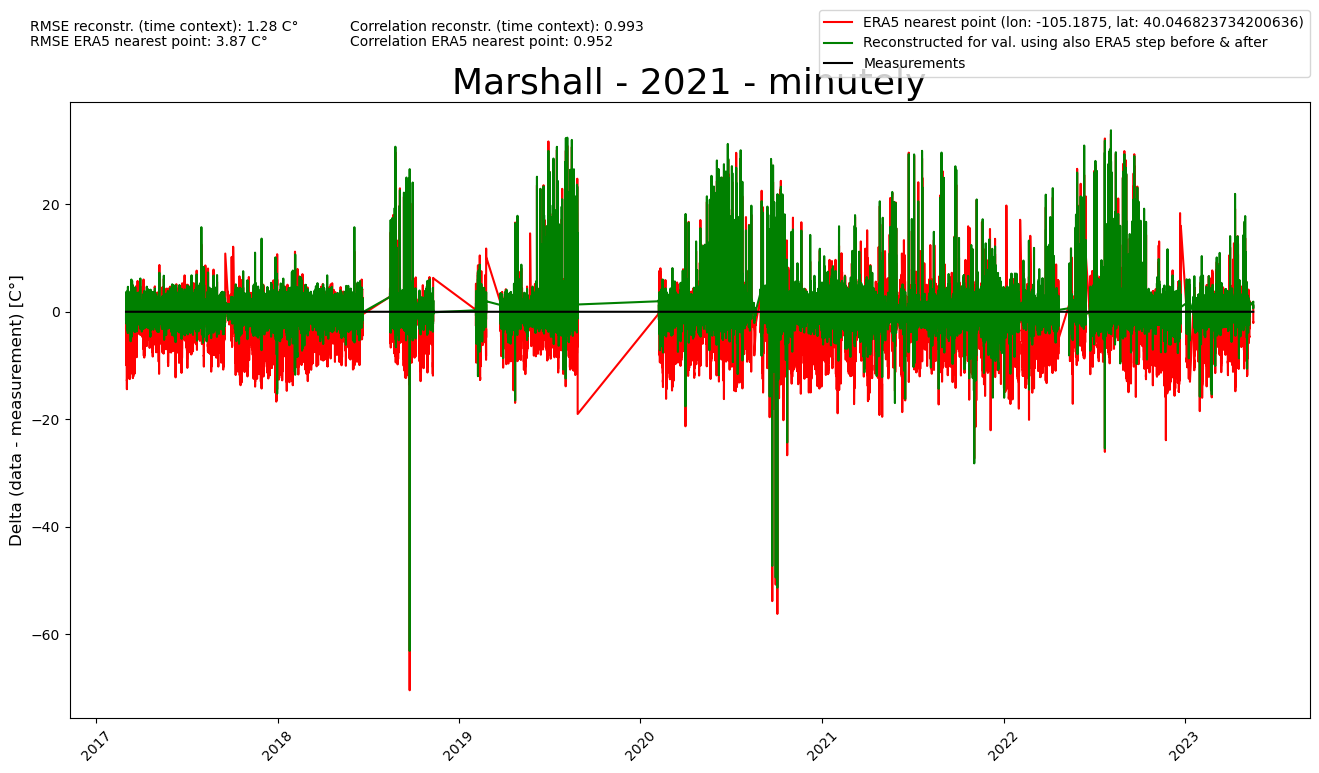

In [114]:
title = f"{station_name} - {test_year} - minutely"
plot_n_steps_of_df(minutely_df, as_delta=True, title=title, plot_trailing_time=True)

# Plotting random Day minutely

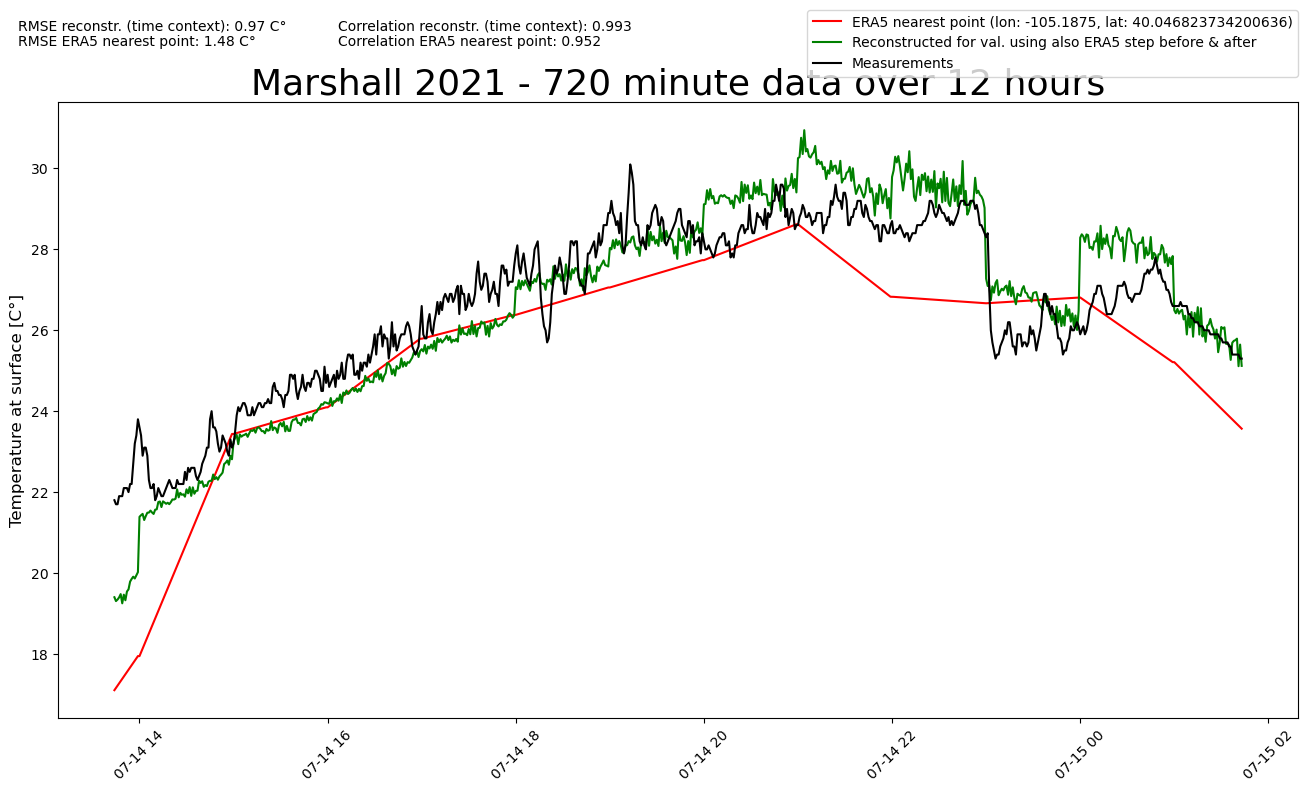

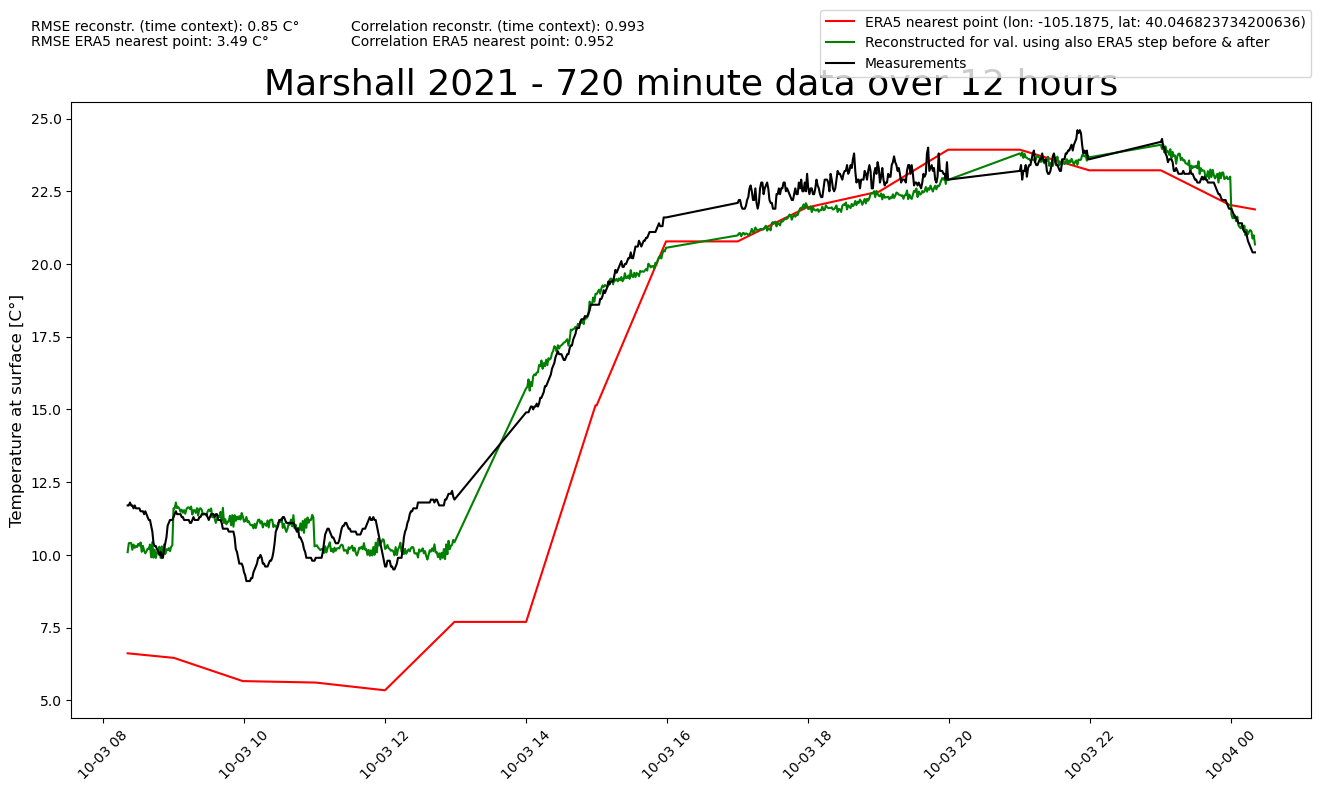

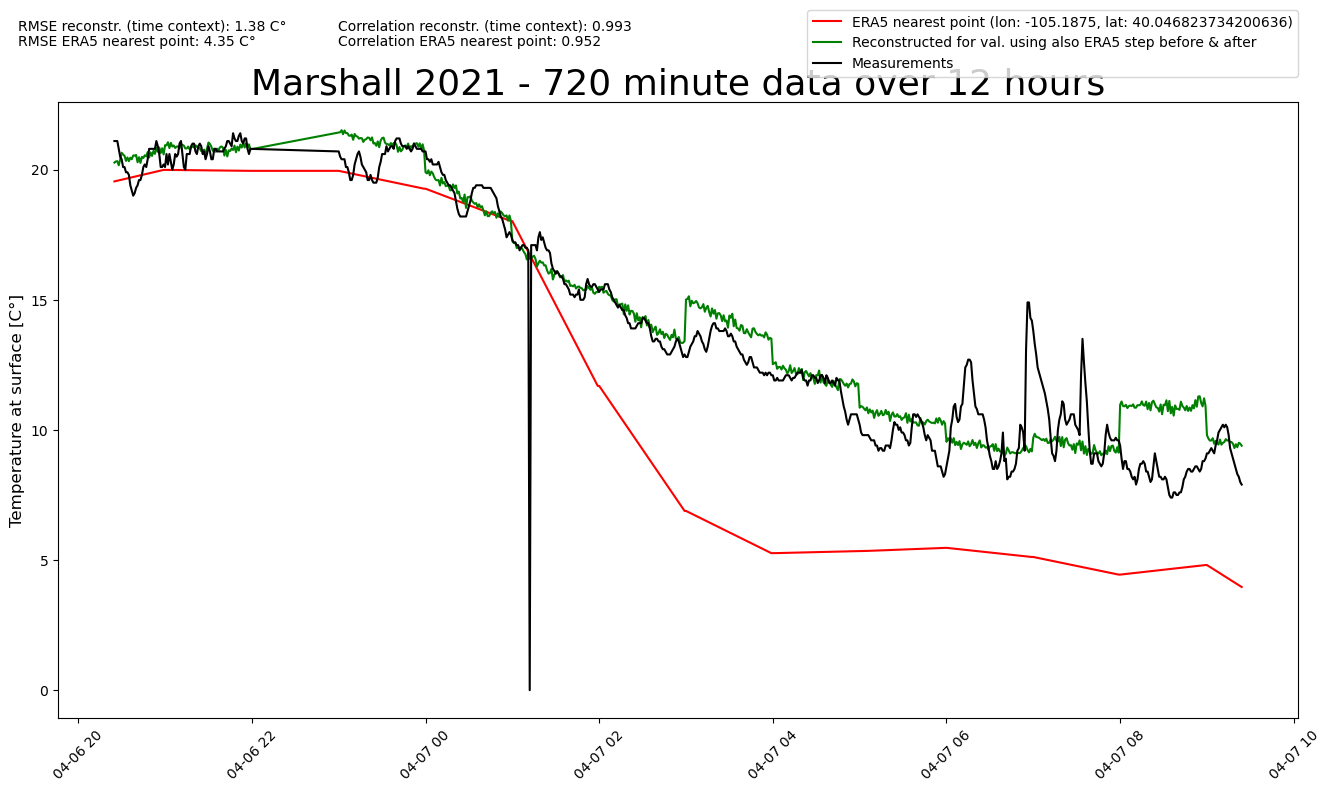

In [101]:
n = 720
title = f"{station_name} {test_year} - {n} minute data over 12 hours"
for _ in range(3):
    plot_n_steps_of_df(minutely_df, as_delta=False, n=n, title=title, plot_trailing_time=True)

# Hourly Analysis

In [107]:
hourly_df = minutely_df.resample('H').mean()


# print a section of the df

start_date = test_year.__str__() + "-01-01"
end_date = test_year.__str__() + "-12-31"

hourly_df = hourly_df[start_date:end_date]

## ...over the full year

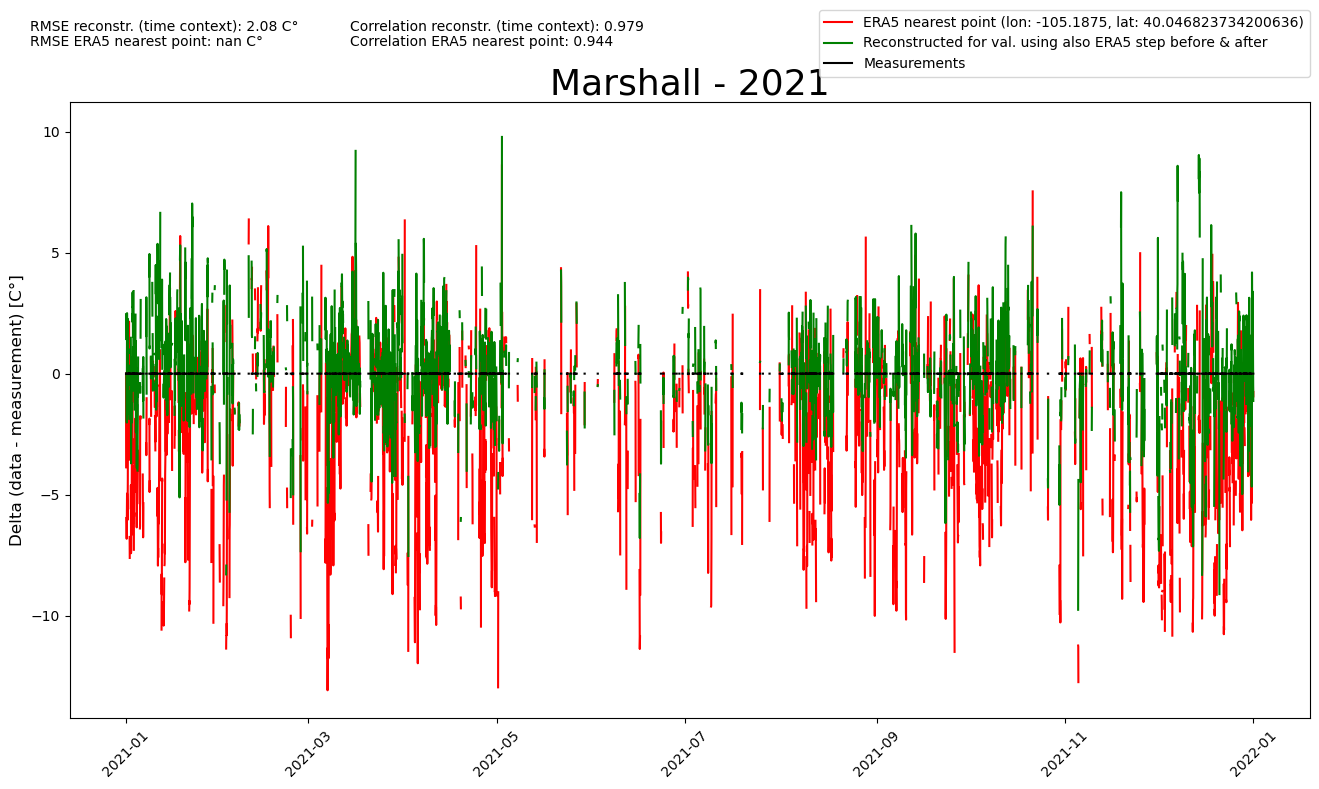

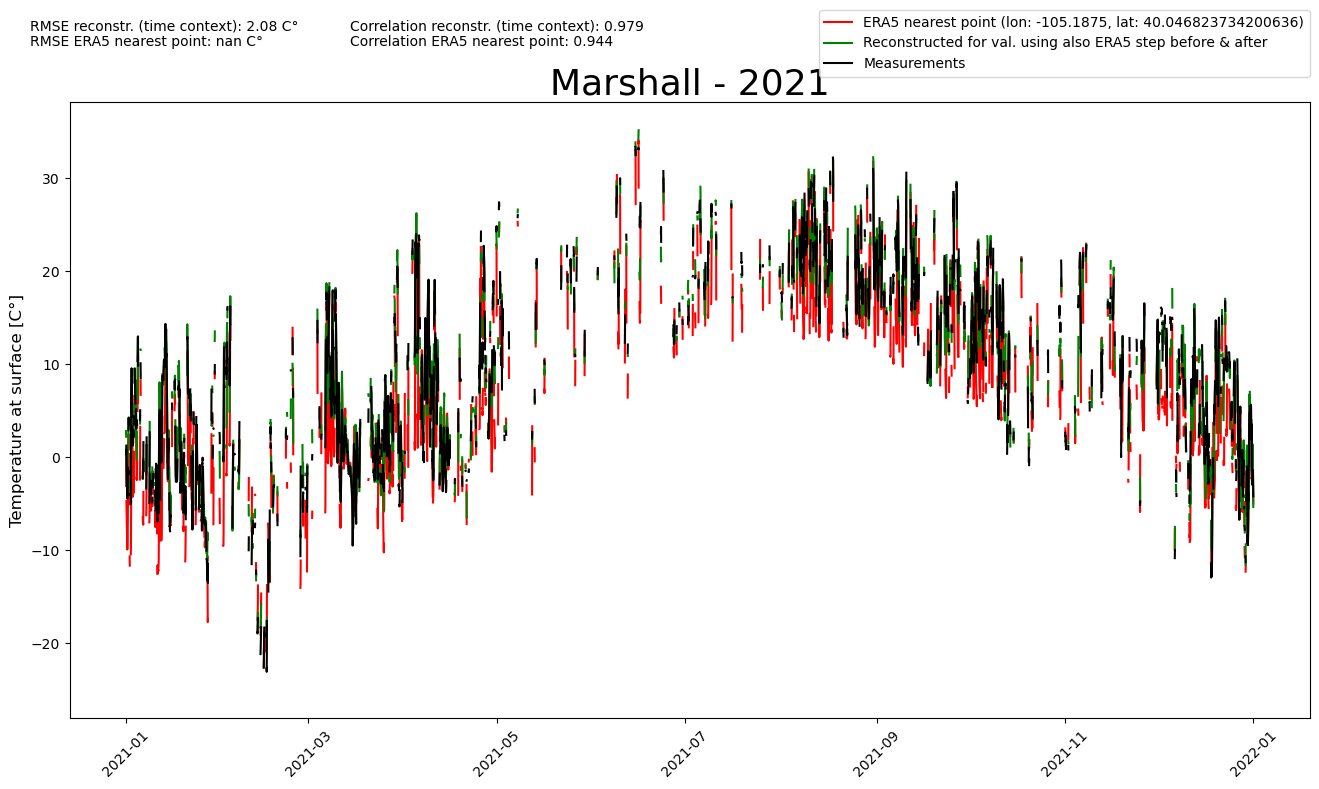

In [108]:
title = f"{station_name} - {test_year}"
plot_n_steps_of_df(hourly_df, as_delta=True, title=title, plot_trailing_time=True)
plot_n_steps_of_df(hourly_df, as_delta=False, title=title, plot_trailing_time=True)

## ...over random weeks

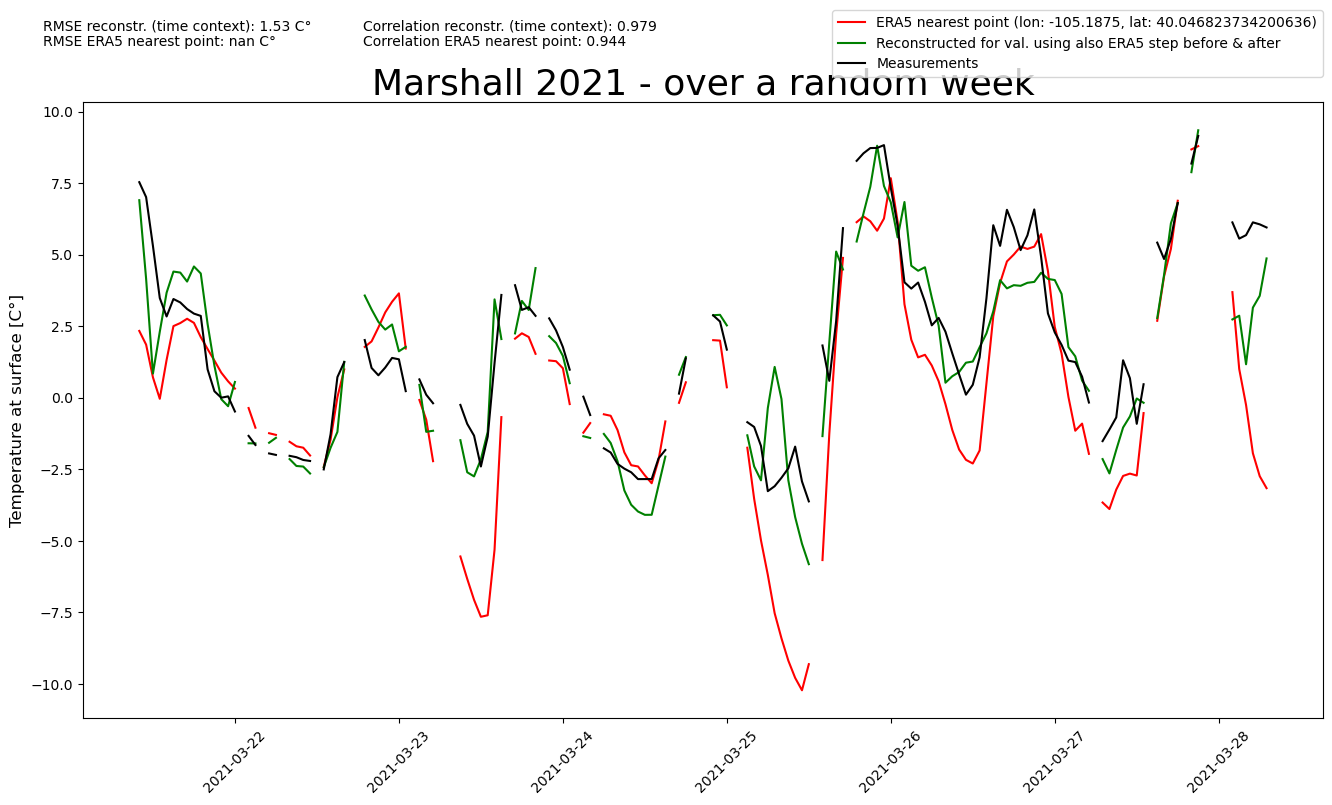

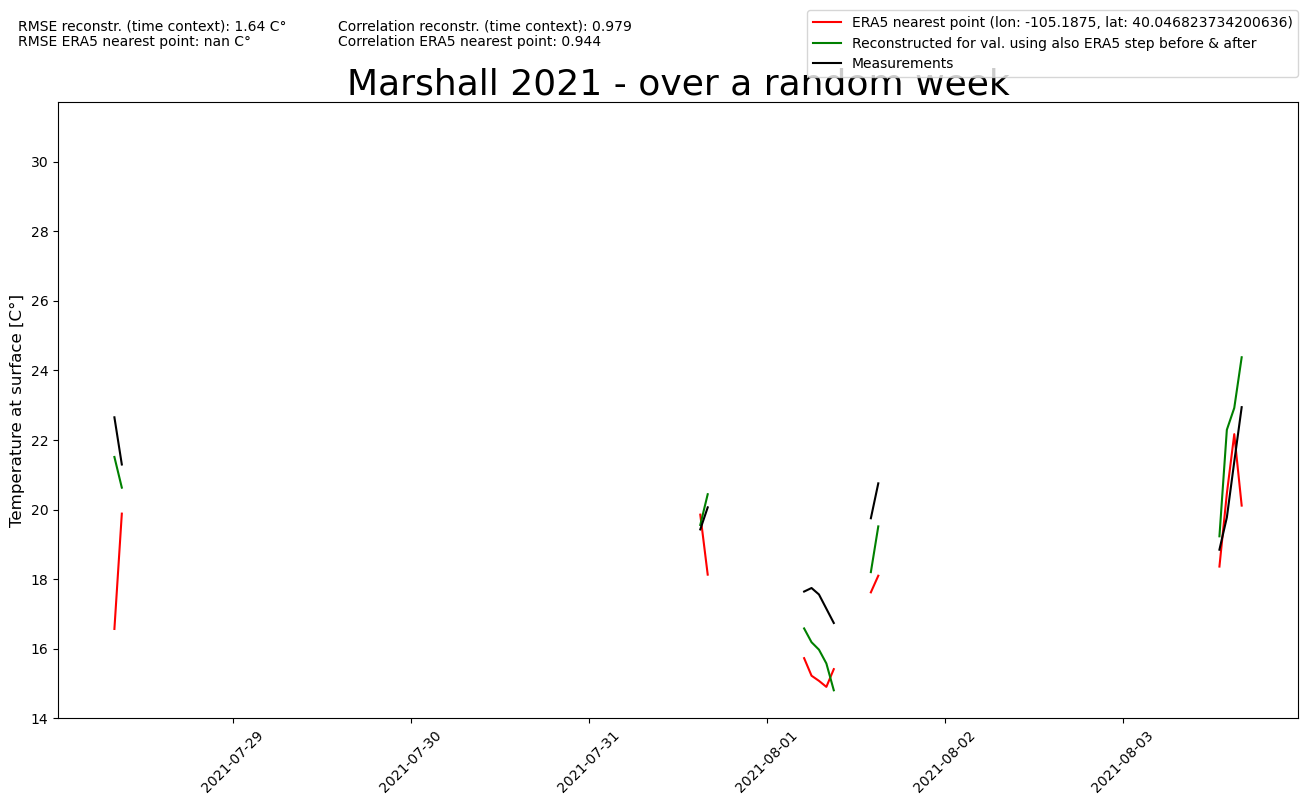

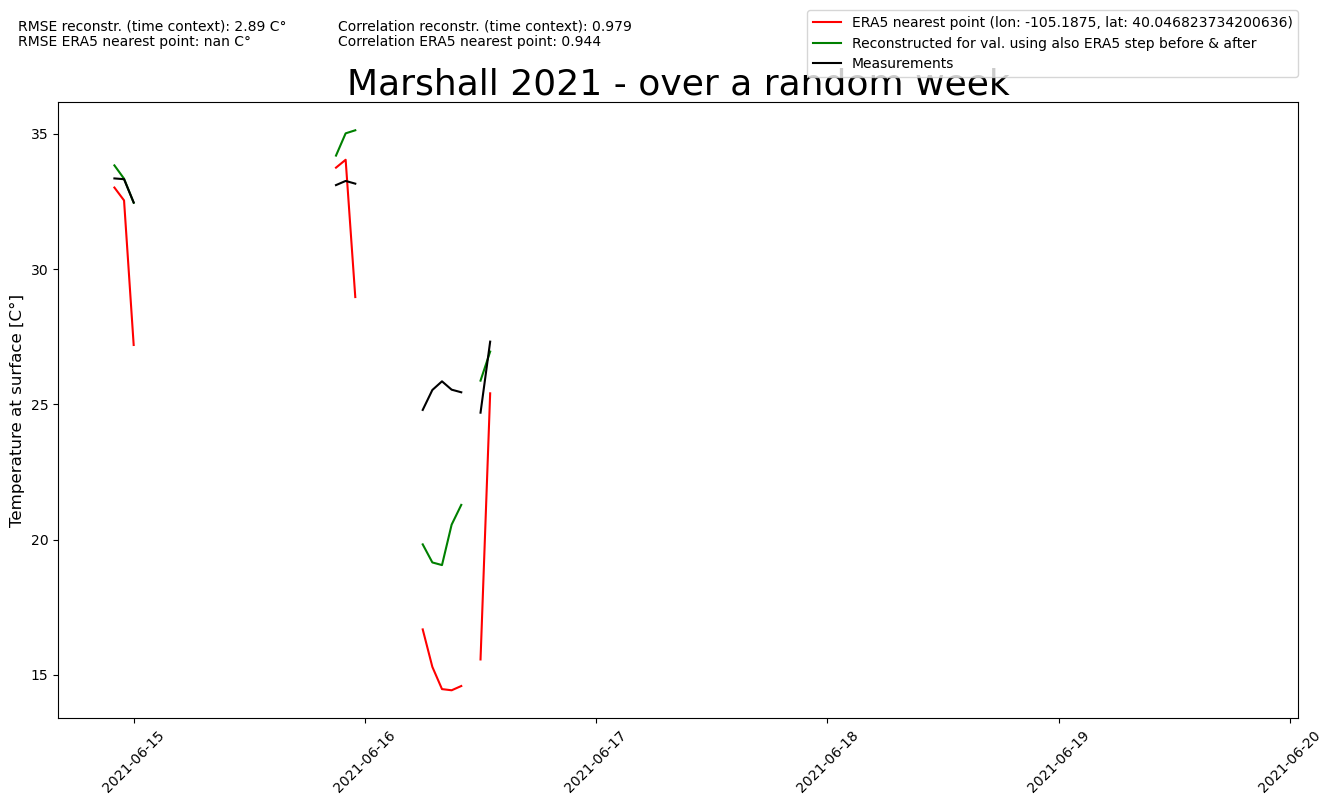

In [109]:
n = 168
if n == 168:
    title = f"{station_name} {test_year} - over a random week"
else:
    title = f"{station_name} {test_year} - {n} random consecutive hourly steps"
for _ in range(3):
    plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title, plot_trailing_time=True)

## Resample Data from hourly to daily or monthly




/tmp/ipykernel_1025179/953675197.py:46: RuntimeWarning: Mean of empty slice
  rmse_reconstructed_with_time_context = np.sqrt(np.nanmean((reconstructed_median_with_time_context_values[time_slice] - measurements_values[time_slice])**2))
/tmp/ipykernel_1025179/953675197.py:47: RuntimeWarning: Mean of empty slice.
  rmse_era5_nearest = np.sqrt(((era5_nearest_values[time_slice] - measurements_values[time_slice])**2).mean())
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


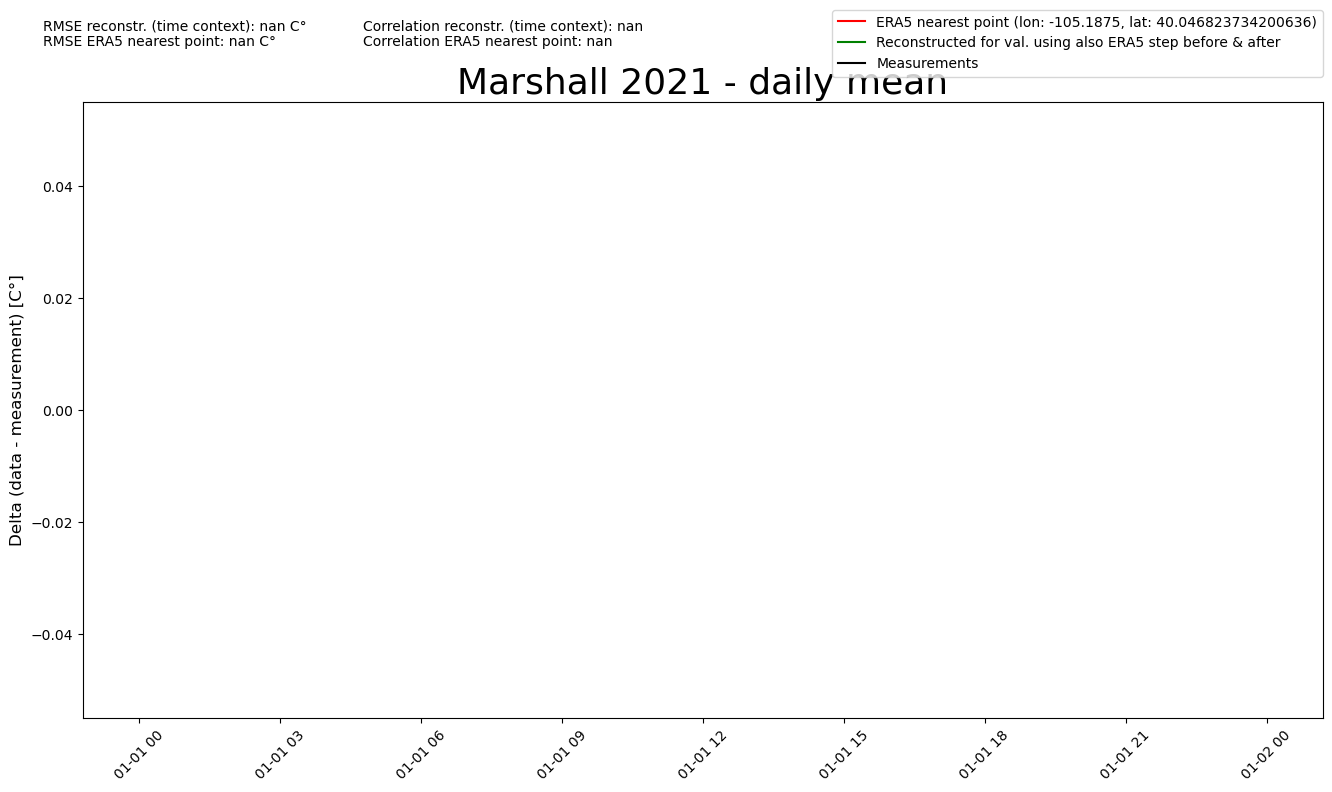

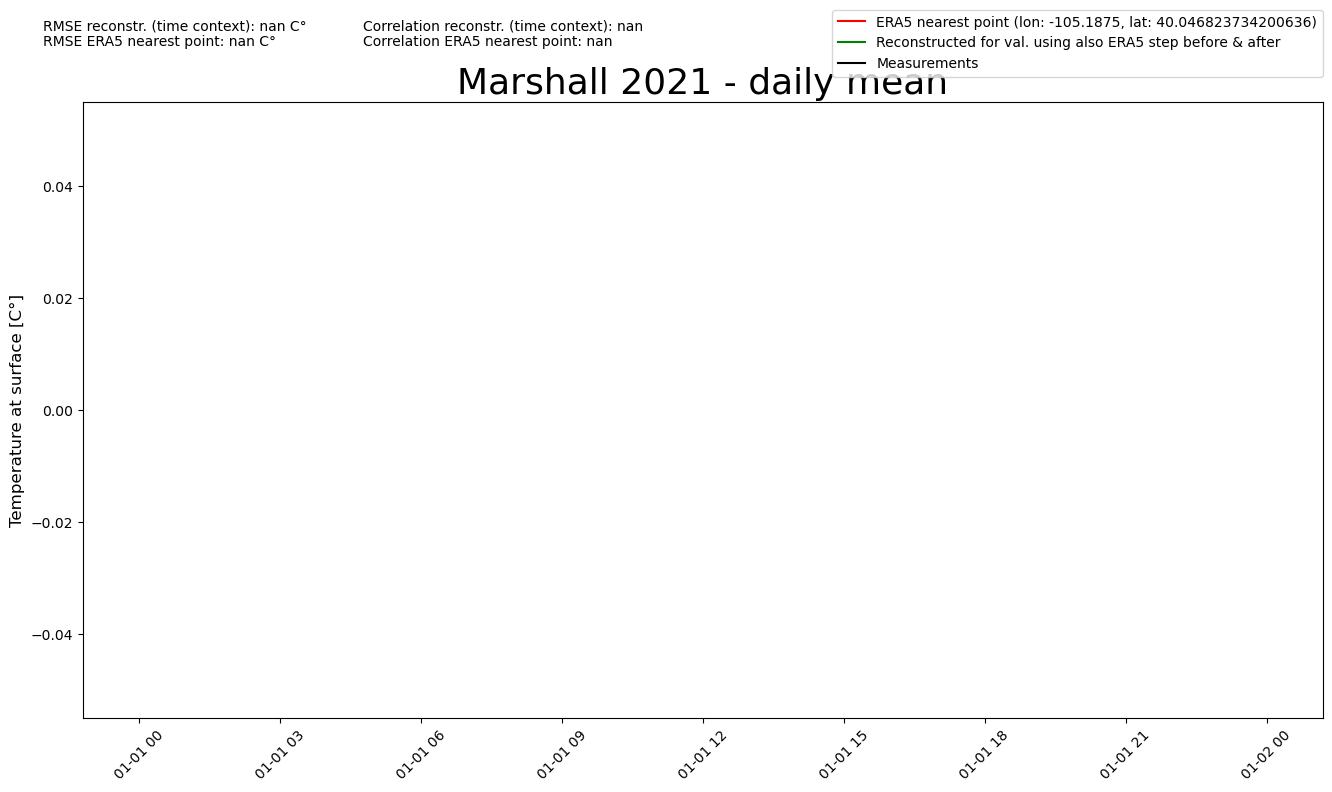

In [110]:
# resample to daily mean
daily_df = hourly_df.resample("D").mean()
# drop nans
daily_df = daily_df.dropna()
title = f"{station_name} {test_year} - daily mean"
plot_n_steps_of_df(daily_df, as_delta=True, title=title, plot_trailing_time=True)
plot_n_steps_of_df(daily_df, as_delta=False, title=title, plot_trailing_time=True)

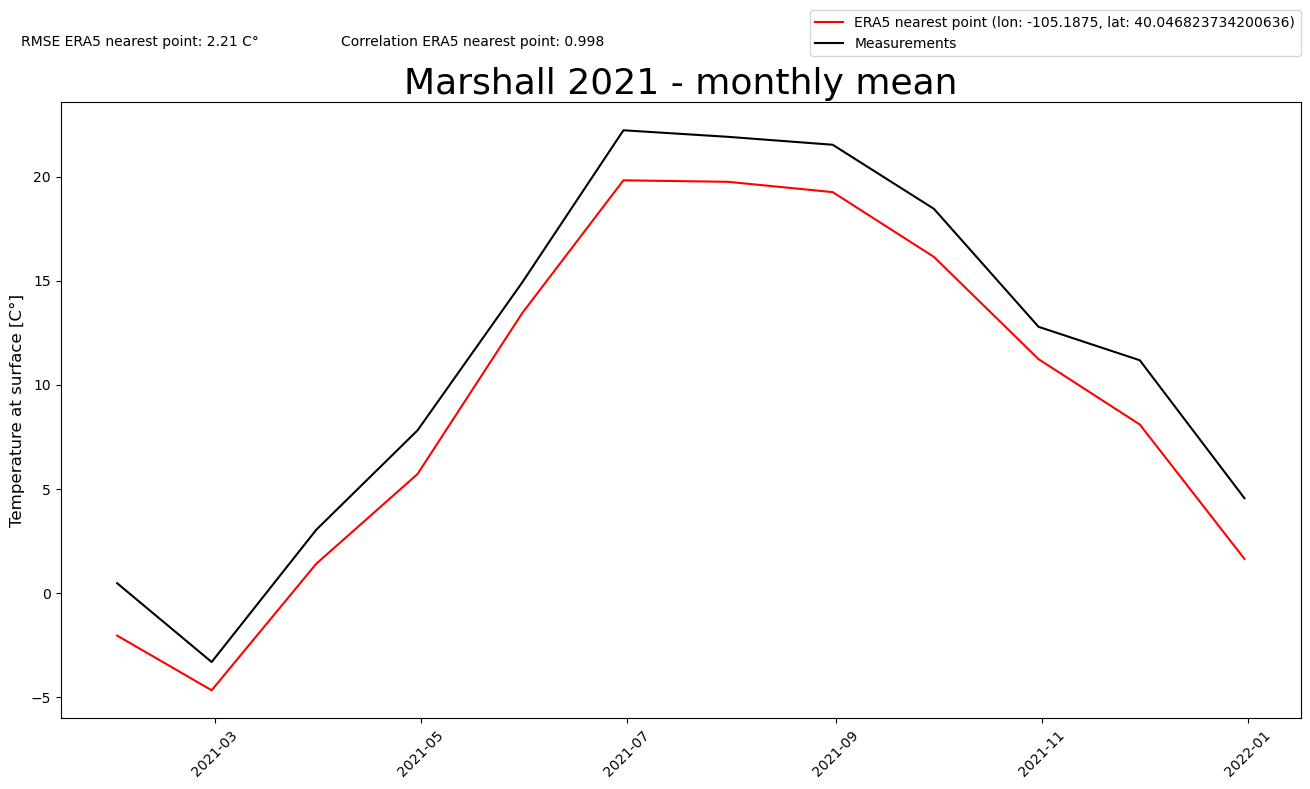

In [111]:
# resample rows to monthly mean
df = hourly_df.resample("M").mean()
title = f"{station_name} {test_year} - monthly mean"
plot_n_steps_of_df(df, as_delta = False, title=title)

/tmp/ipykernel_1025179/953675197.py:46: RuntimeWarning: Mean of empty slice
  rmse_reconstructed_with_time_context = np.sqrt(np.nanmean((reconstructed_median_with_time_context_values[time_slice] - measurements_values[time_slice])**2))
/tmp/ipykernel_1025179/953675197.py:47: RuntimeWarning: Mean of empty slice.
  rmse_era5_nearest = np.sqrt(((era5_nearest_values[time_slice] - measurements_values[time_slice])**2).mean())
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


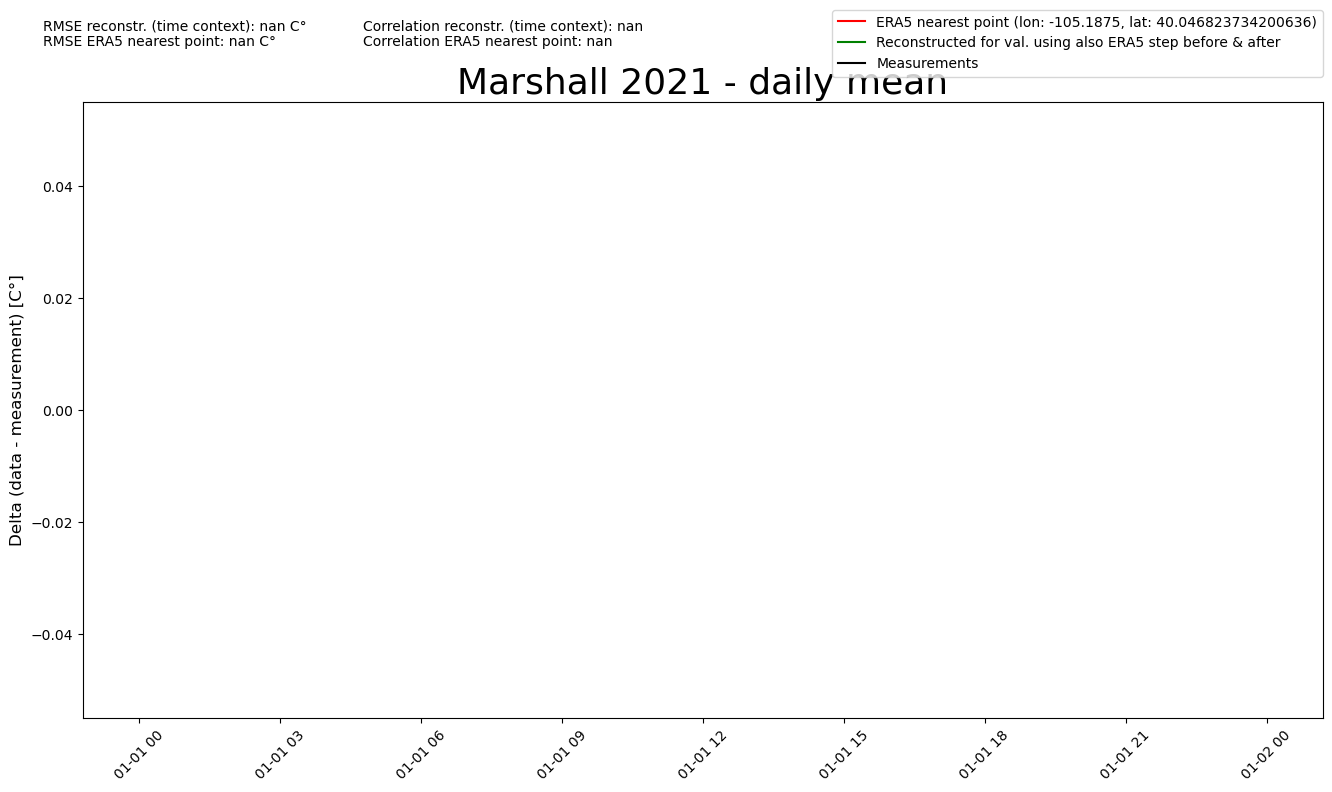

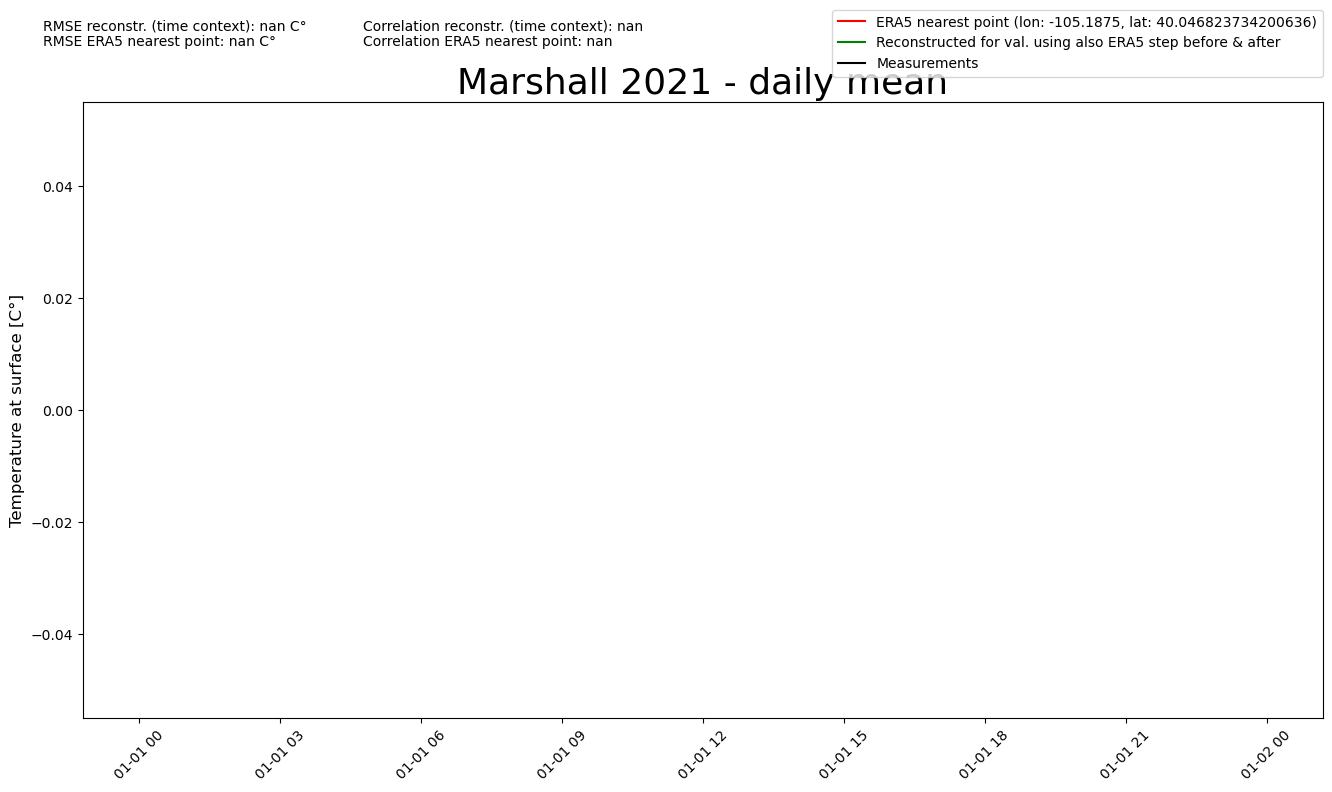

In [112]:
# resample to daily mean
daily_df = hourly_df.resample("D").mean()
# drop nans
daily_df = daily_df.dropna()
title = f"{station_name} {test_year} - daily mean"
plot_n_steps_of_df(daily_df, as_delta=True, title=title, plot_trailing_time=True)
plot_n_steps_of_df(daily_df, as_delta=False, title=title, plot_trailing_time=True)

# Average Course of a day

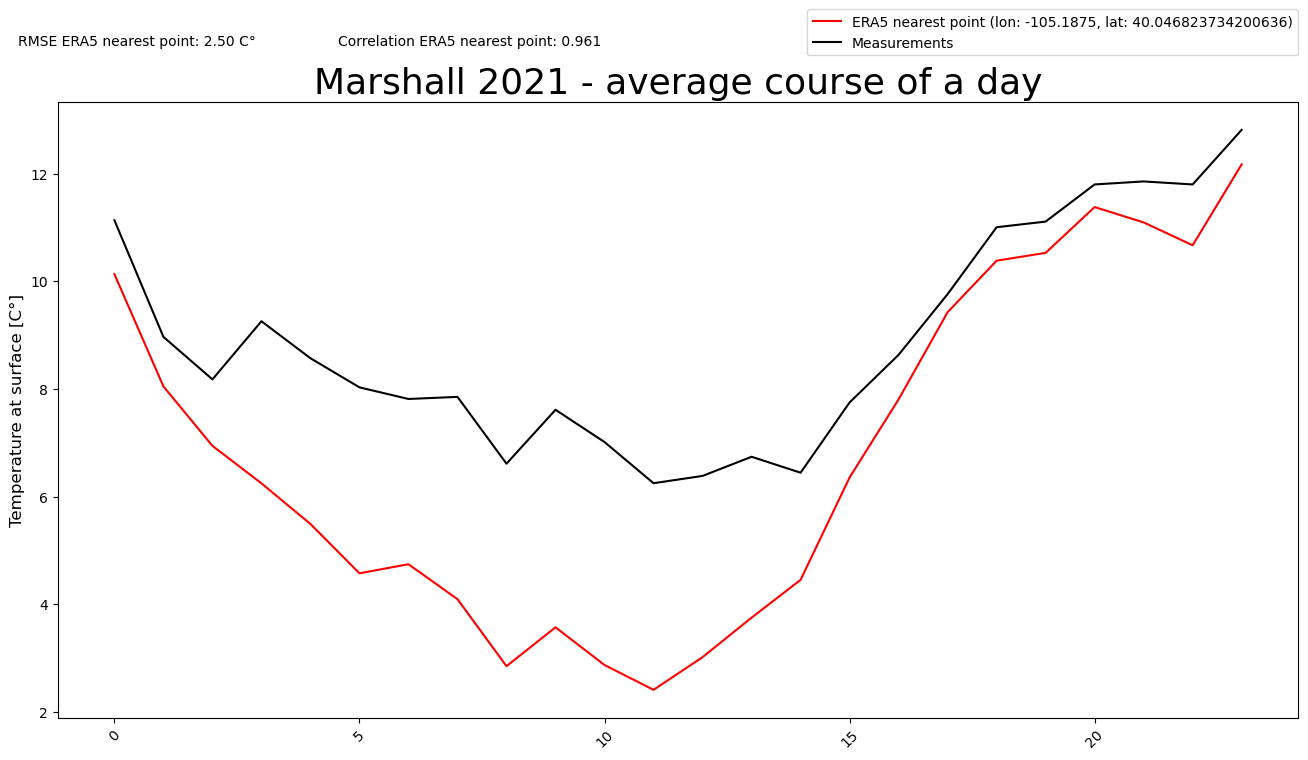

In [113]:
# calculate the mean of each 24 hours over the whole year

day_course_df = hourly_df.groupby(hourly_df.index.hour).mean()
title = f"{station_name} {test_year} - average course of a day"
plot_n_steps_of_df(day_course_df, as_delta = False, title=title)

# Average Course of a month

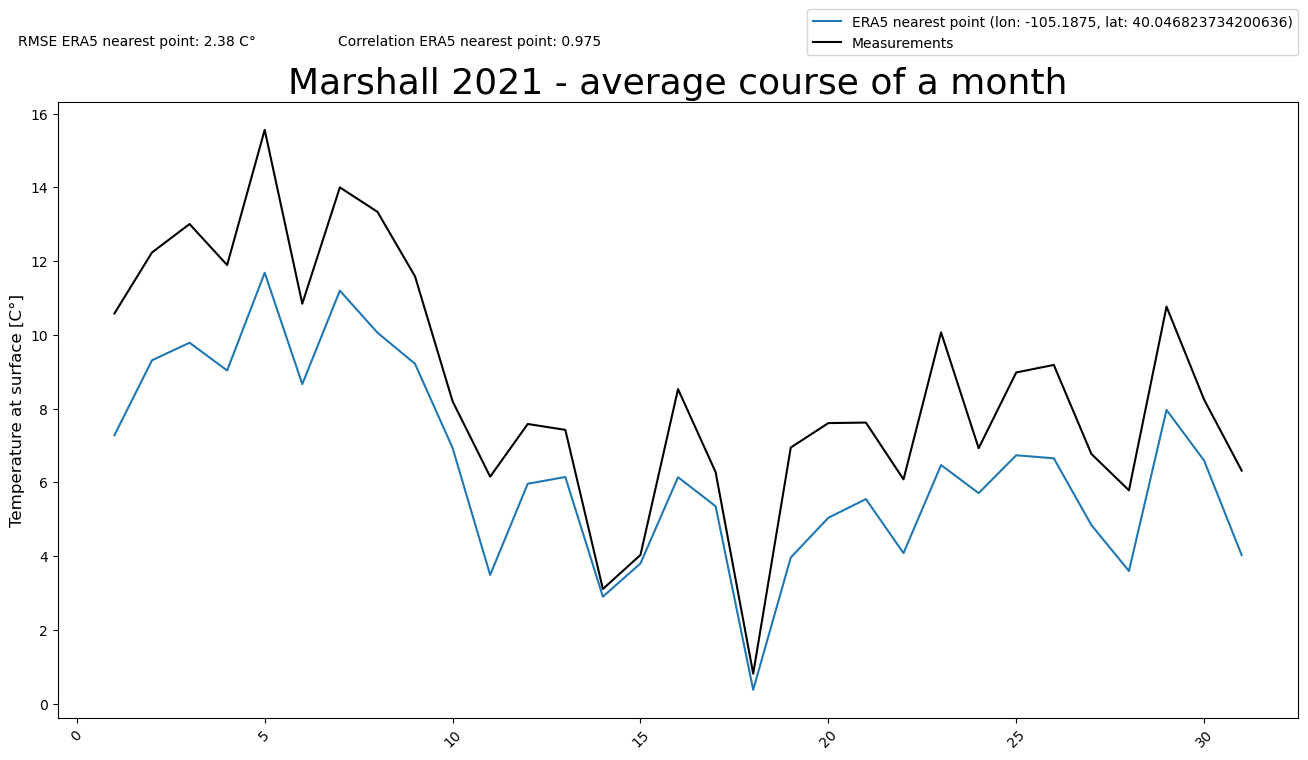

In [ ]:
# calculate the mean of each day of a month over the whole year

month_course_df = hourly_df.groupby(hourly_df.index.day).mean()
title = f"{station_name} {test_year} - average course of a month"
plot_n_steps_of_df(month_course_df, as_delta = False, title=title)

## Evaluate for the actually missing time steps

In [ ]:
evaluate_wrapper(use_time_context = False, iter = at_iterations, station = station_name, reconstruct_gaps=True)
output_filled_gaps_ds = DataSet(output_file_path, name="Reconstructed gaps")
output_actual_gaps_data = xr.open_dataset(output_file_path)

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


In [ ]:
def create_filled_in_gaps_df(full_era5_data, filled_gaps_data, measurements_data):

    import pandas as pd

    def single_df(time, tas, name):
        df = pd.DataFrame()
        df["time"] = time
        df.set_index("time", inplace=True)
        df[name] = tas
        return df
    
    lon_left_idx, lon_right_idx, lon_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    lat_left_idx, lat_right_idx, lat_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat)

    era5_nearest_values = full_era5_data.variables["tas"][:, lon_nearest_idx, lat_nearest_idx]
    reconstructed_values = filled_gaps_data.variables["tas"].stack(grid=['lat', 'lon']).values
    reconstructed_values = [np.median(x) for x in reconstructed_values]
    
    measurements_values = measurements_data.variables["tas"].stack(grid=['lat', 'lon']).values
    measurements_values = [np.median(x) for x in measurements_values]
    
    era_df = single_df(full_era5_data.variables["time"], era5_nearest_values, "era5_nearest")
    reconstructed_df = single_df(filled_gaps_data.variables["time"], reconstructed_values, "filled_in_gaps")
    measurements_df = single_df(measurements_data.variables["time"], measurements_values, "measurements")
    
    # merge on time
    merged = pd.concat([era_df, reconstructed_df, measurements_df], axis=1)
    # drop rows where reconstructed and measurements are both nan simultaneously
    return merged.dropna(subset=["filled_in_gaps", "measurements"], how="all")
    
    

In [ ]:
hourly_filled_gaps_df = create_filled_in_gaps_df(era5_full_data, output_actual_gaps_data, measurements_data)
hourly_filled_gaps_df

era5_nearest  filled_in_gaps  measurements
time                                                           
2017-03-01 05:00:00    269.790222      269.832092           NaN
2017-03-01 06:00:00    270.518555      267.737396           NaN
2017-03-01 07:00:00    270.043579      267.802856           NaN
2017-03-01 08:00:00    263.223724      268.856720           NaN
2017-03-01 09:00:00    262.905365      266.871277           NaN
...                           ...             ...           ...
2023-11-29 14:00:00    262.271576      276.102234           NaN
2023-11-29 15:00:00    263.555298      277.880676           NaN
2023-11-29 16:00:00    268.792786      277.371429           NaN
2023-11-29 17:00:00    274.536865      278.312714           NaN
2023-11-29 18:00:00    278.119110      278.821899           NaN

[59150 rows x 3 columns]

In [ ]:
def plot_n_steps_of_filled_in_df(df, n=None, title=None, show_in_steps=False):

    time = df.index.values

    era5_nearest_values = df["era5_nearest"].values - 273.15
    reconstructed_median_values = df["filled_in_gaps"].values - 273.15
    
    measurements_values = df["measurements"].values - 273.15

    import random

    if n is None:
        n = len(df)
       
    break_loop = 0
    we_have_measurements_and_reconstructed_values_in_this_timeframe = False 
    while not we_have_measurements_and_reconstructed_values_in_this_timeframe and break_loop < 1000:
            
        # random slice of n consecutive datapoints
        
        slice_start = random.randint(0, len(time) - n)
        time_slice = slice(slice_start, slice_start + n)

        if n == len(df):
            we_have_measurements_and_reconstructed_values_in_this_timeframe = True
        else:
            break_loop += 1
            # check in time slice if we have measurements and reconstructed values
            we_have_measurements_and_reconstructed_values_in_this_timeframe = not (np.all(np.isnan(measurements_values[time_slice])) or np.all(np.isnan(reconstructed_median_values[time_slice])))
           
    time = time[time_slice]
    
    make_plots_with_era5 = [False, True, True] if show_in_steps else [True]
    make_plots_with_filled = [False, False, True] if show_in_steps else [True]
    for show_era, show_filled in zip(make_plots_with_era5, make_plots_with_filled):
    
        plt.ylabel("Temperature at surface [C°]")
        

        # x-axis labels 90 degrees
        plt.xticks(rotation=45)
        
        # title
        
        if title is not None:
            plt.title(title)
        
        
        # font size of legend
        plt.rcParams.update({'font.size': 10})
        
        # font size of axis labels
        plt.rcParams.update({'axes.labelsize': 12})
        
        # font size of title
        plt.rcParams.update({'axes.titlesize': 26})

    
        # figure size A4 landscape
        plt.gcf().set_size_inches(16, 8)
        
        if show_era:
            plt.plot(time, era5_nearest_values[time_slice], label="ERA5 nearest point", color="grey", linestyle="--" if n <= 168 else "-")  
        
        plt.plot(time, measurements_values[time_slice], label="Measurements", color="black", linestyle="-", marker="o" if n <= 168 else "")
    
        if show_filled:            
            plt.plot(time, reconstructed_median_values[time_slice], label="Reconstructed", color="#d13297", linestyle="-", marker="o" if n <= 168 else "")
    
        plt.legend()
        plt.show()

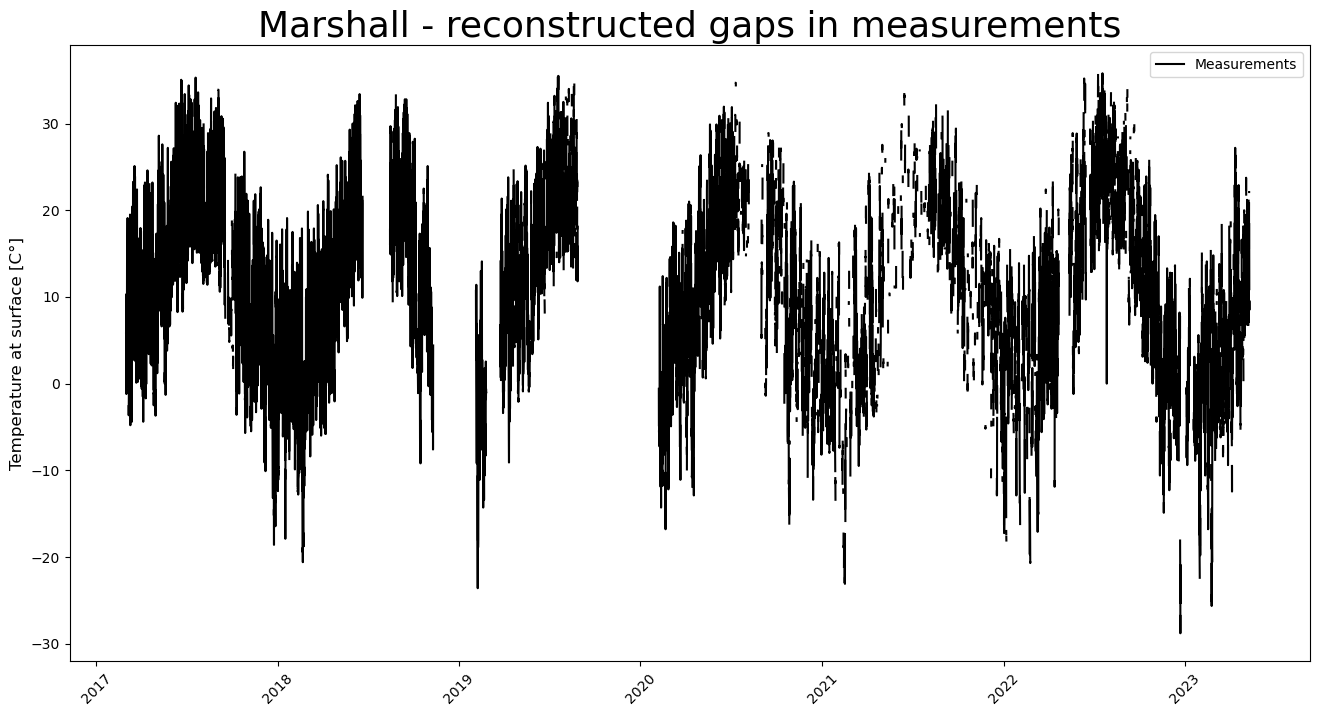

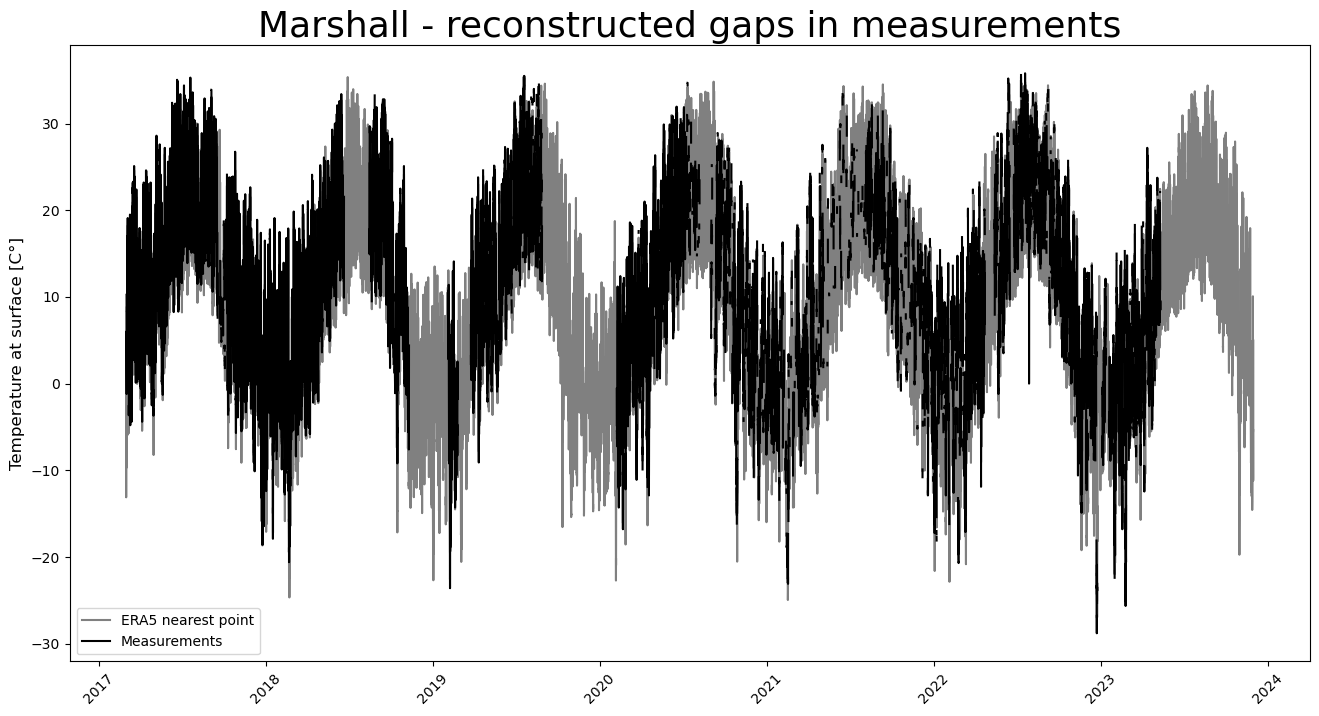

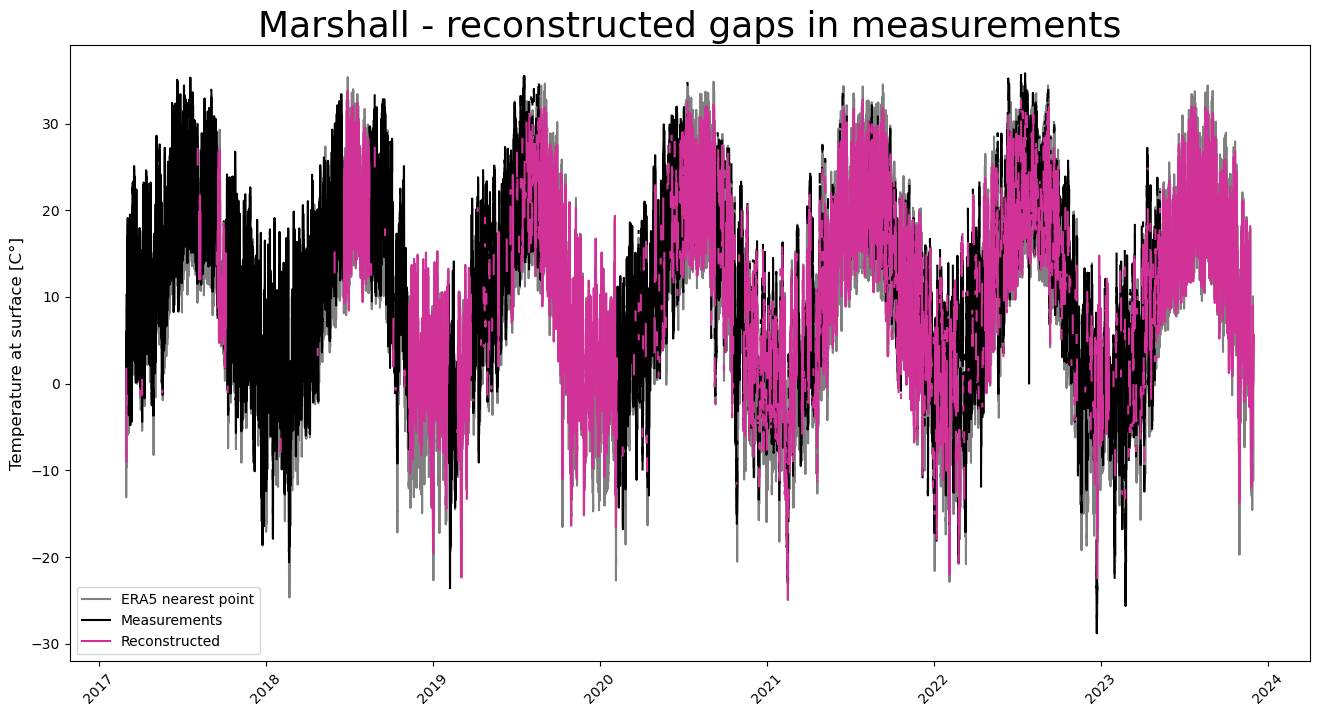

In [ ]:
plot_n_steps_of_filled_in_df(hourly_filled_gaps_df, title=f"{station_name} - reconstructed gaps in measurements", show_in_steps=True)

## Resampled to Daily Mean

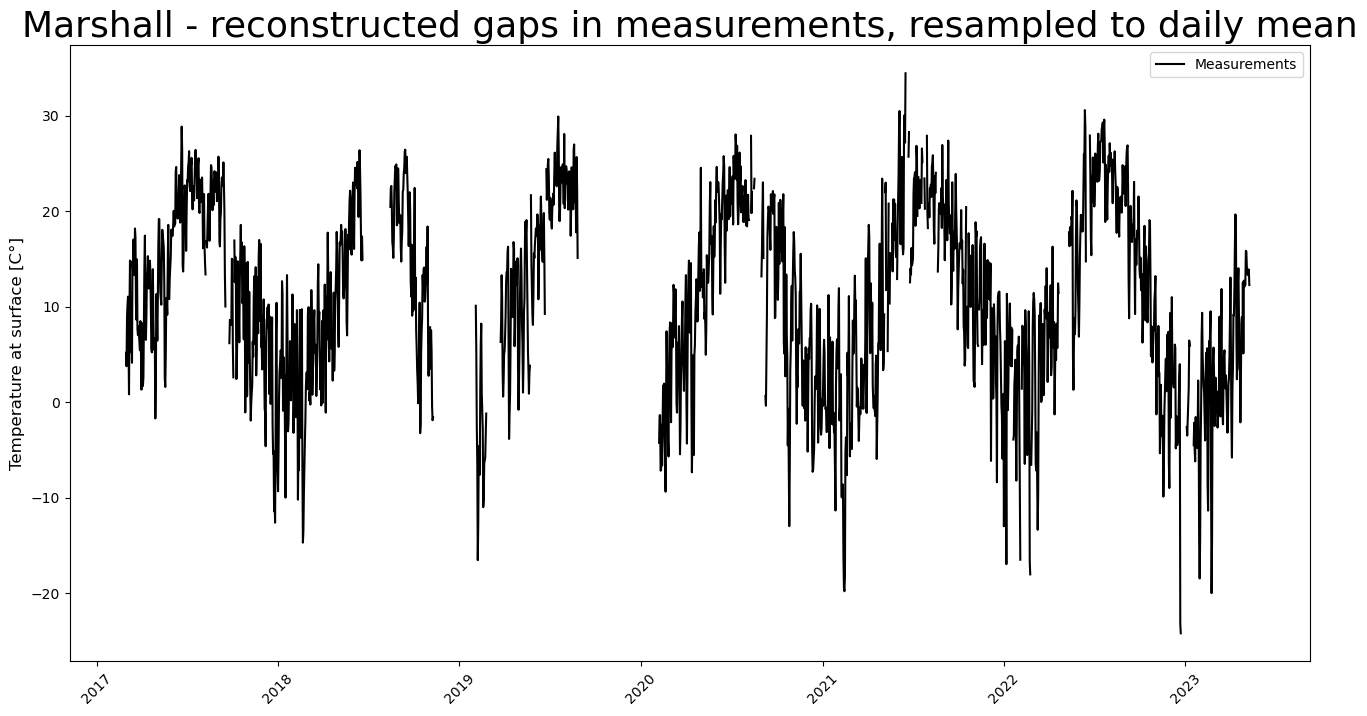

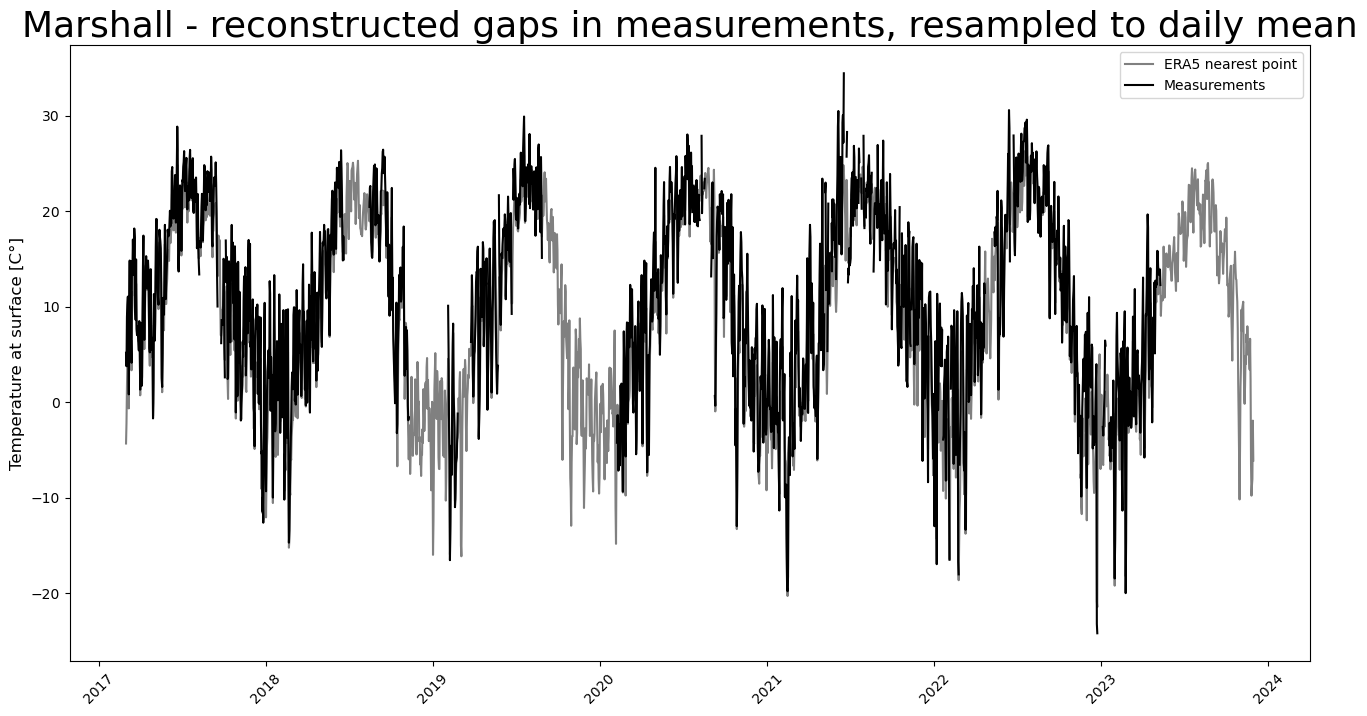

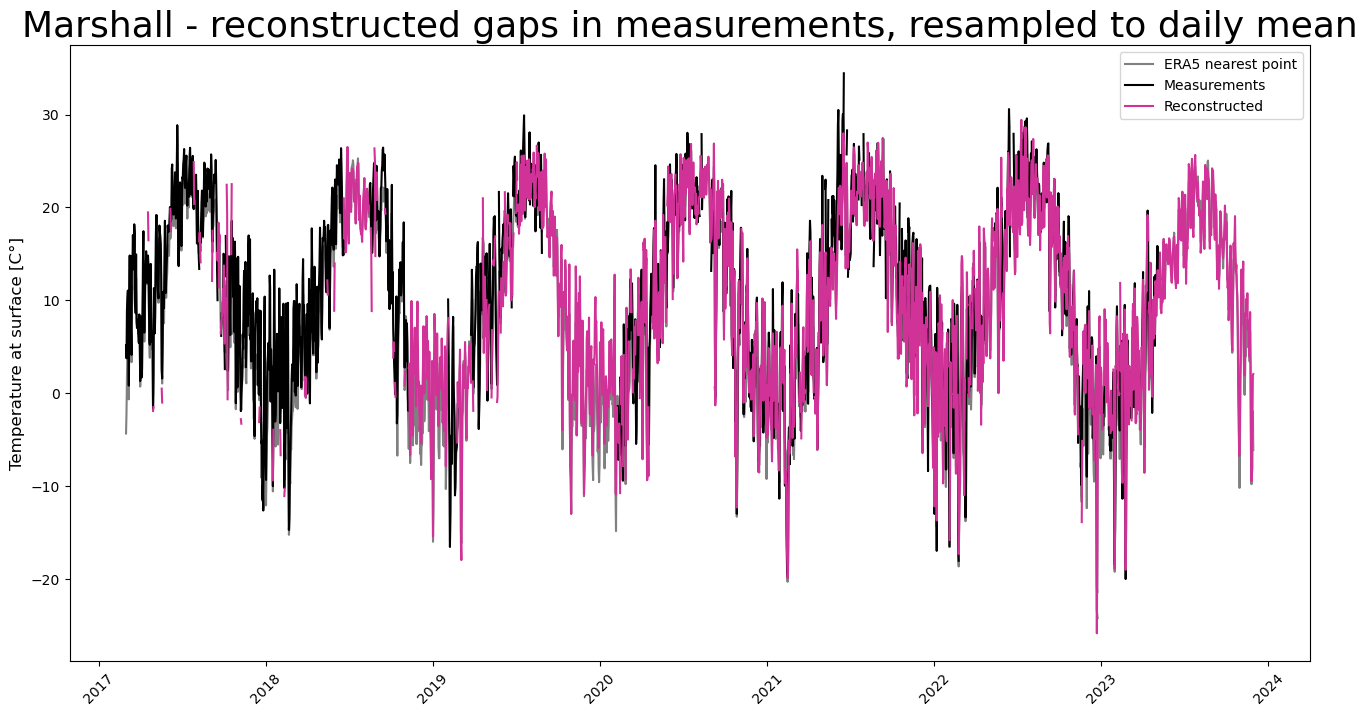

In [ ]:
daily_filled_gaps_df = hourly_filled_gaps_df.resample("D").mean()

plot_n_steps_of_filled_in_df(daily_filled_gaps_df, title=f"{station_name} - reconstructed gaps in measurements, resampled to daily mean", show_in_steps=True)

## Plot random weeks

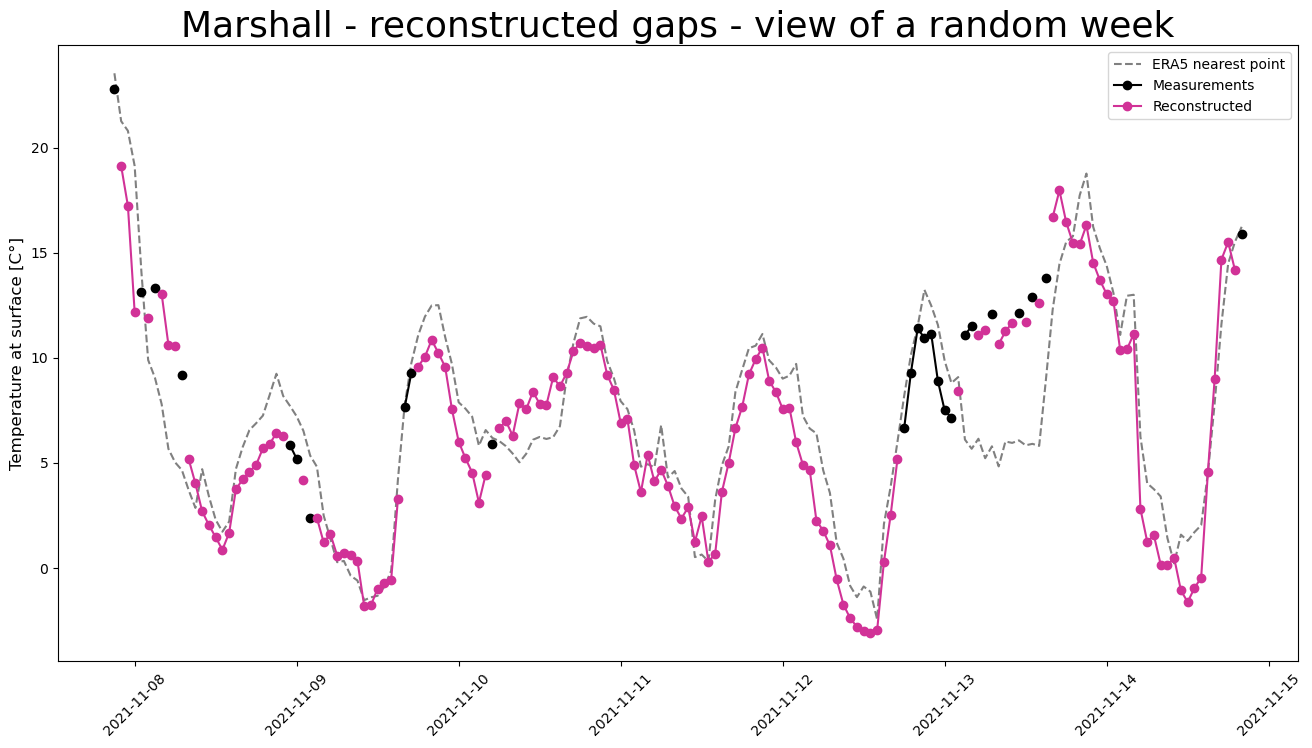

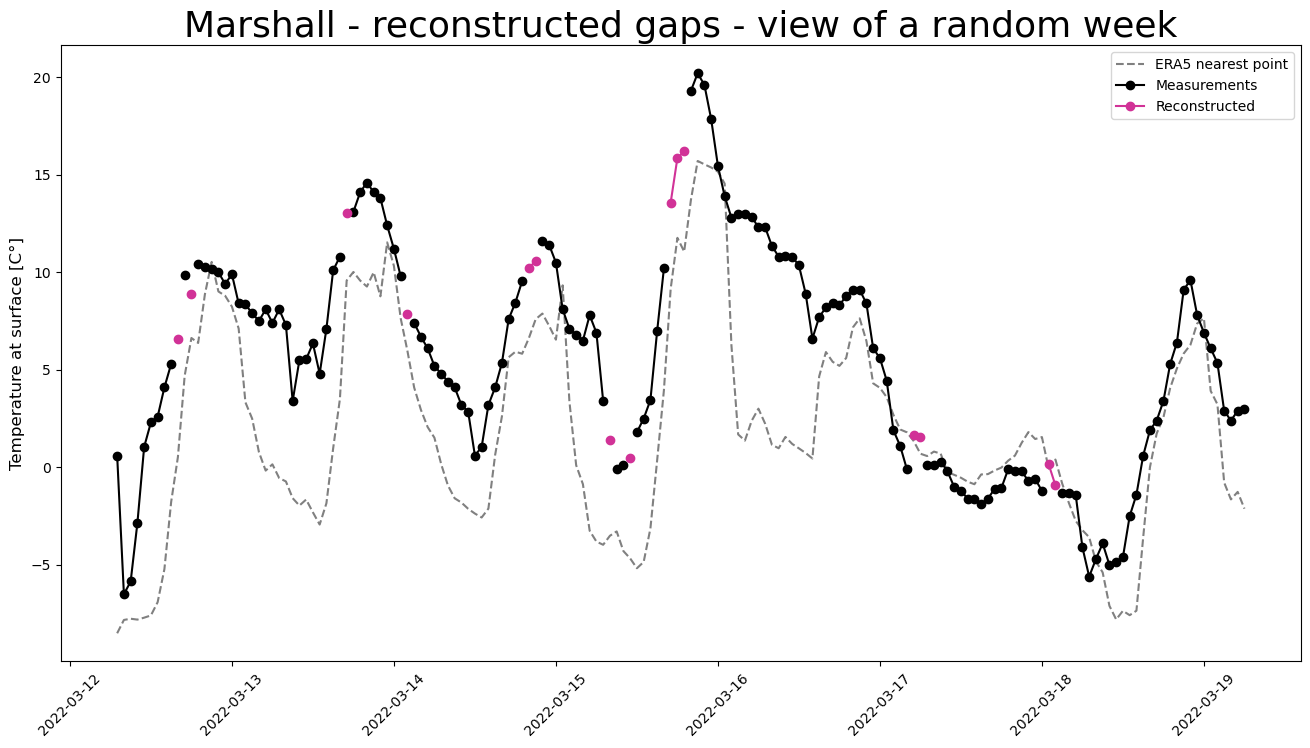

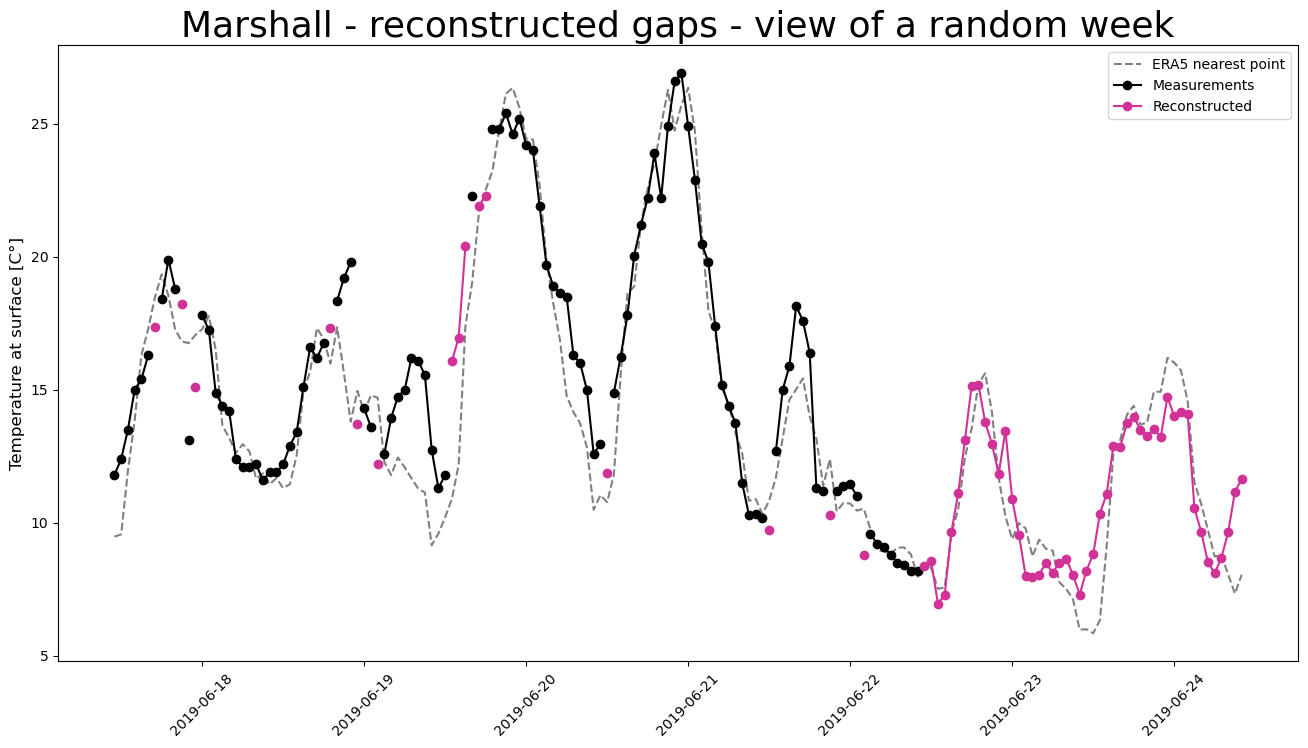

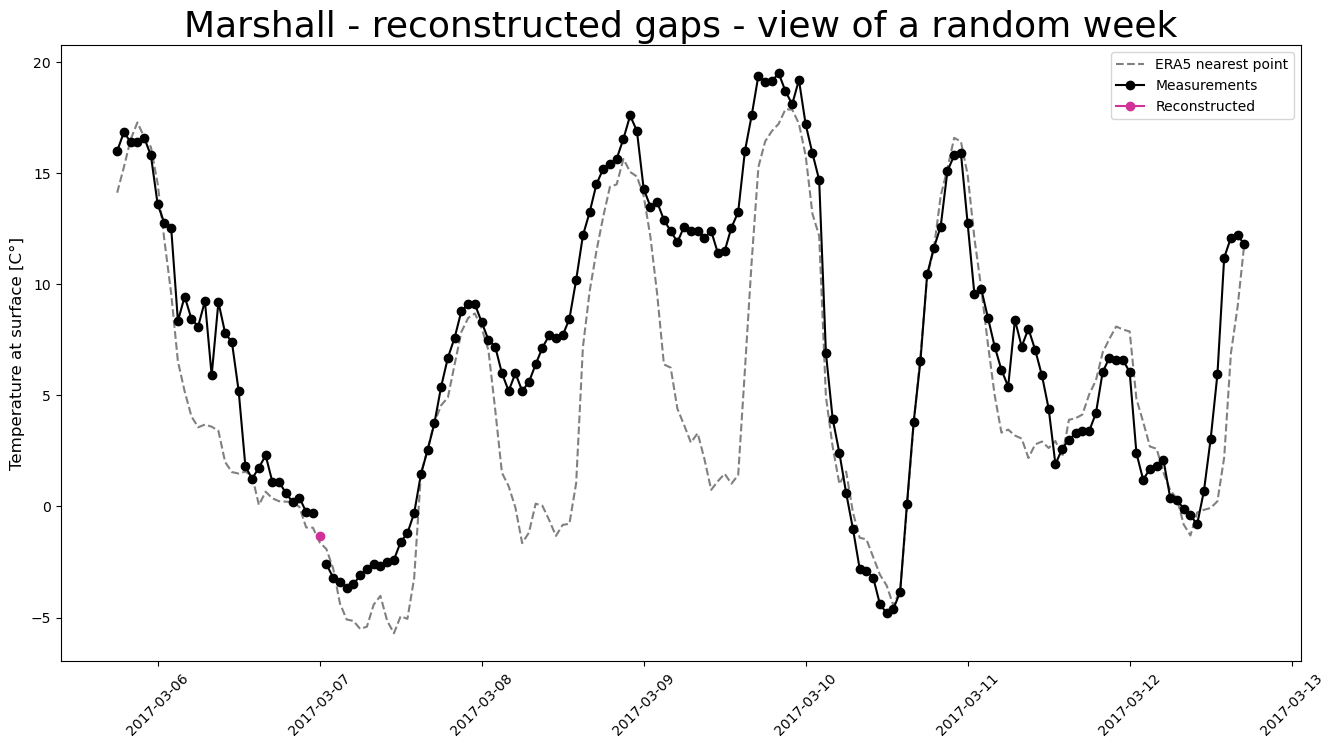

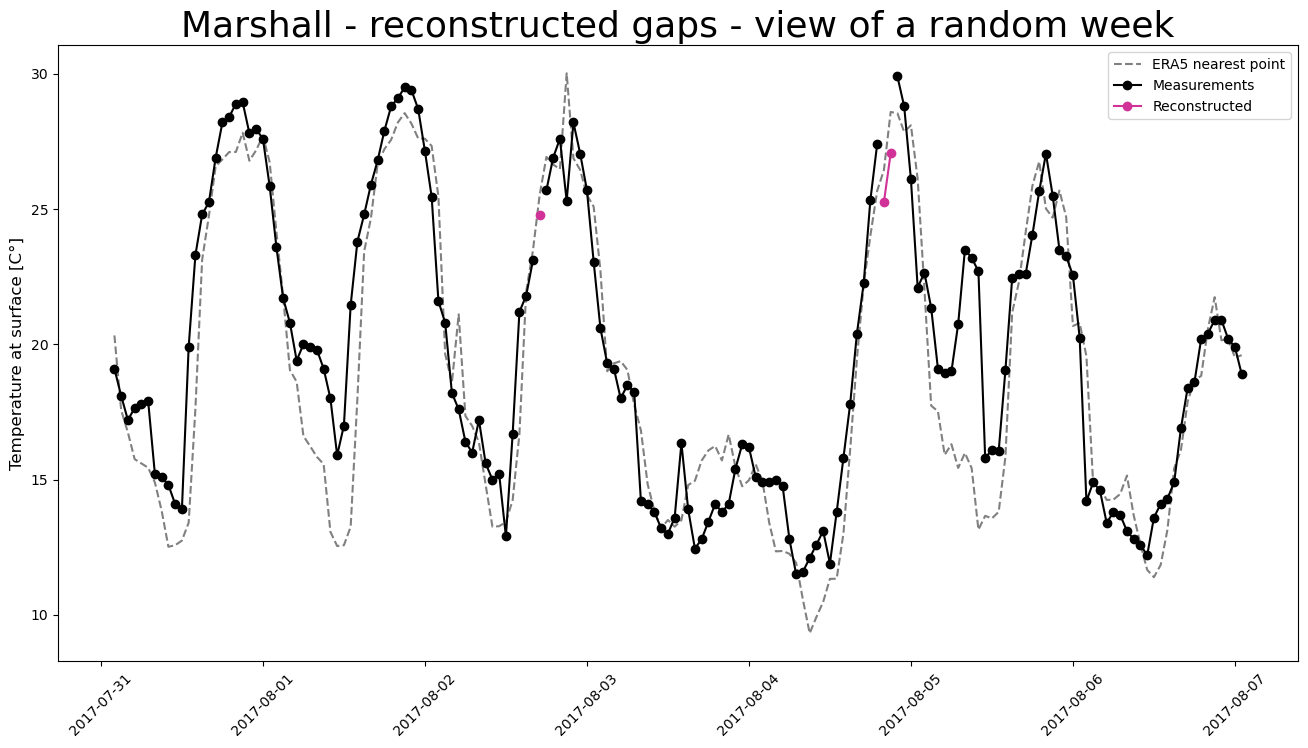

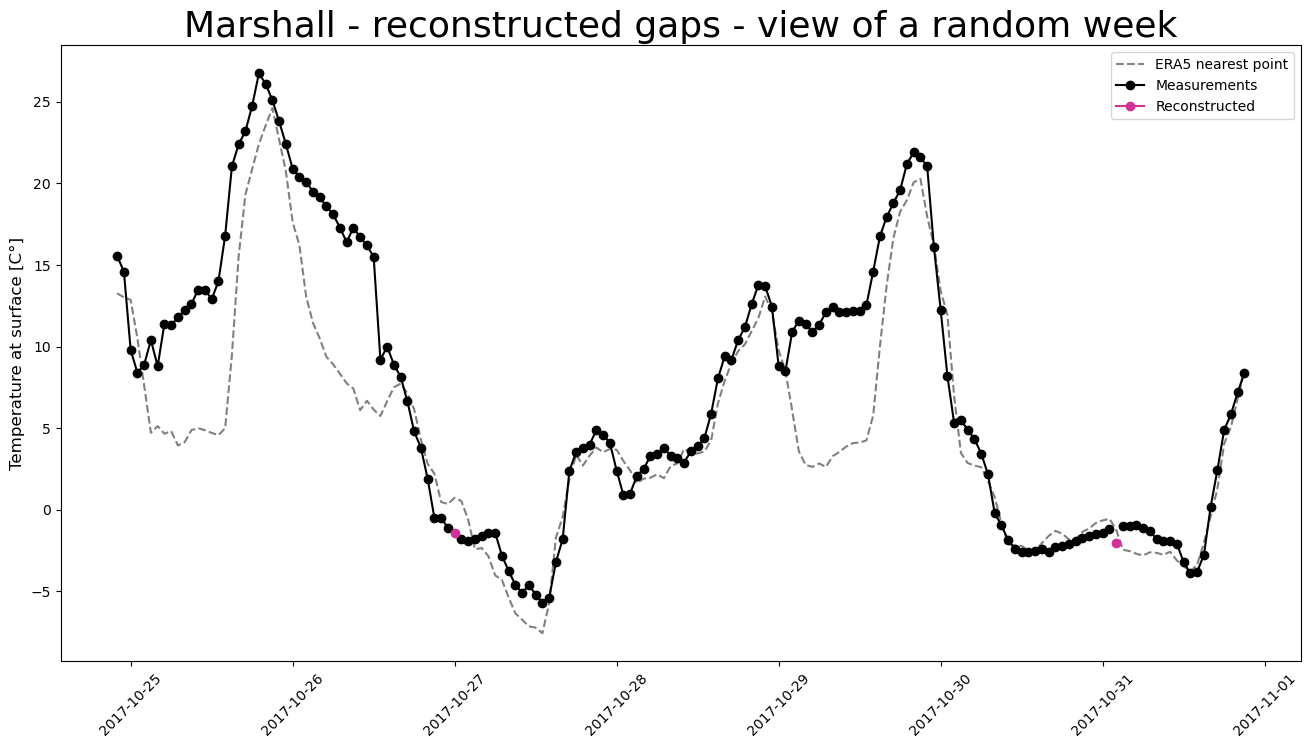

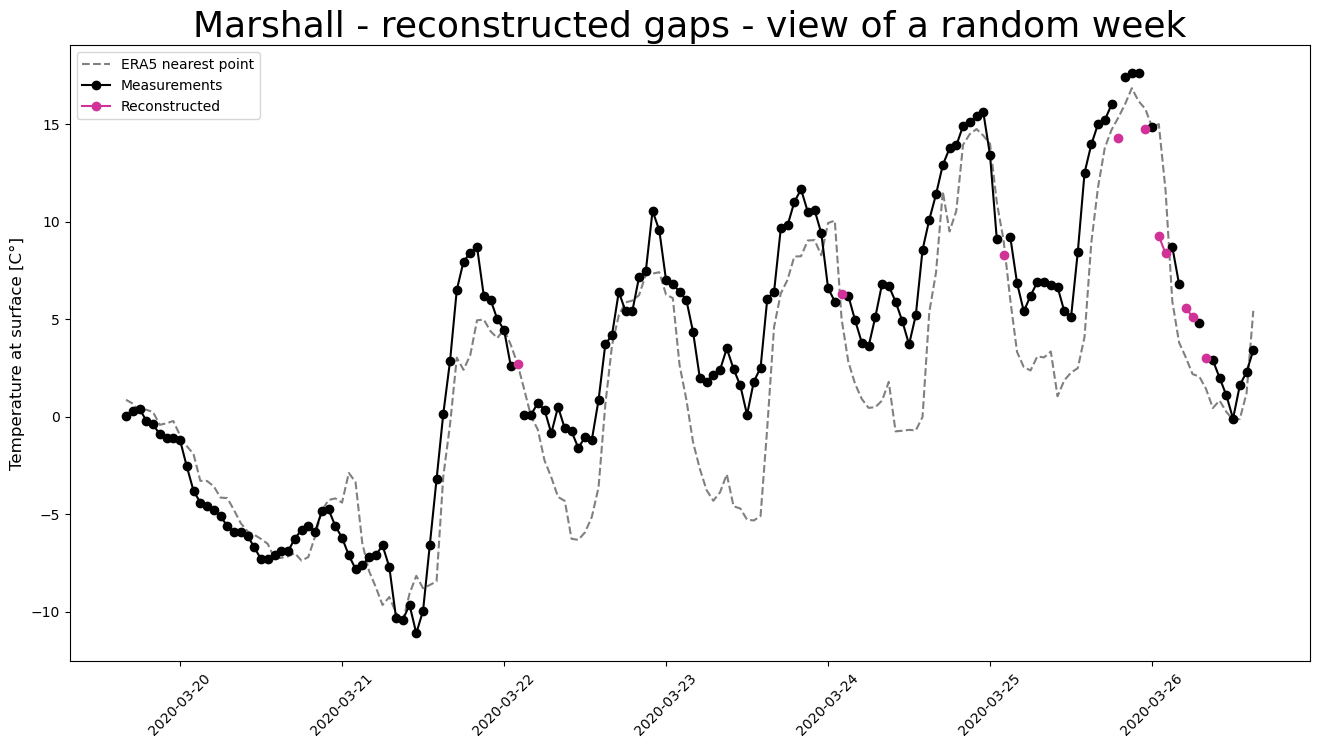

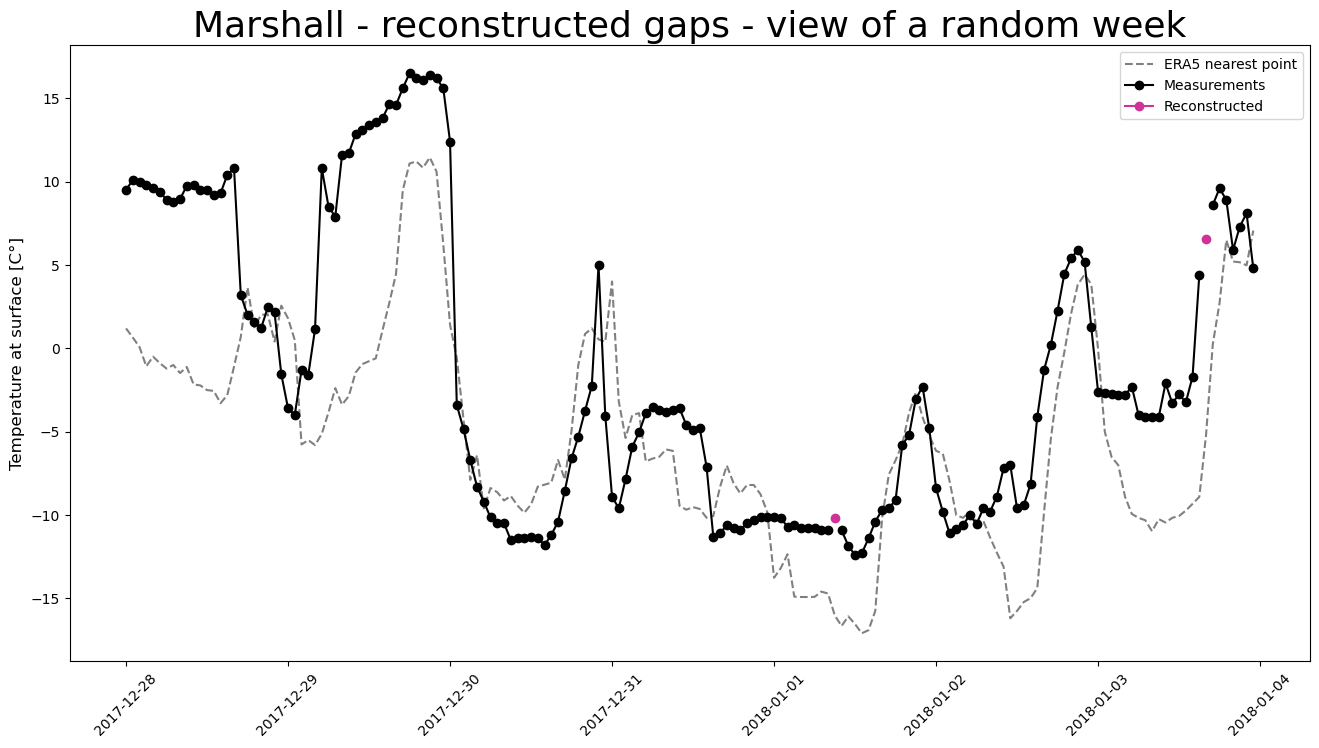

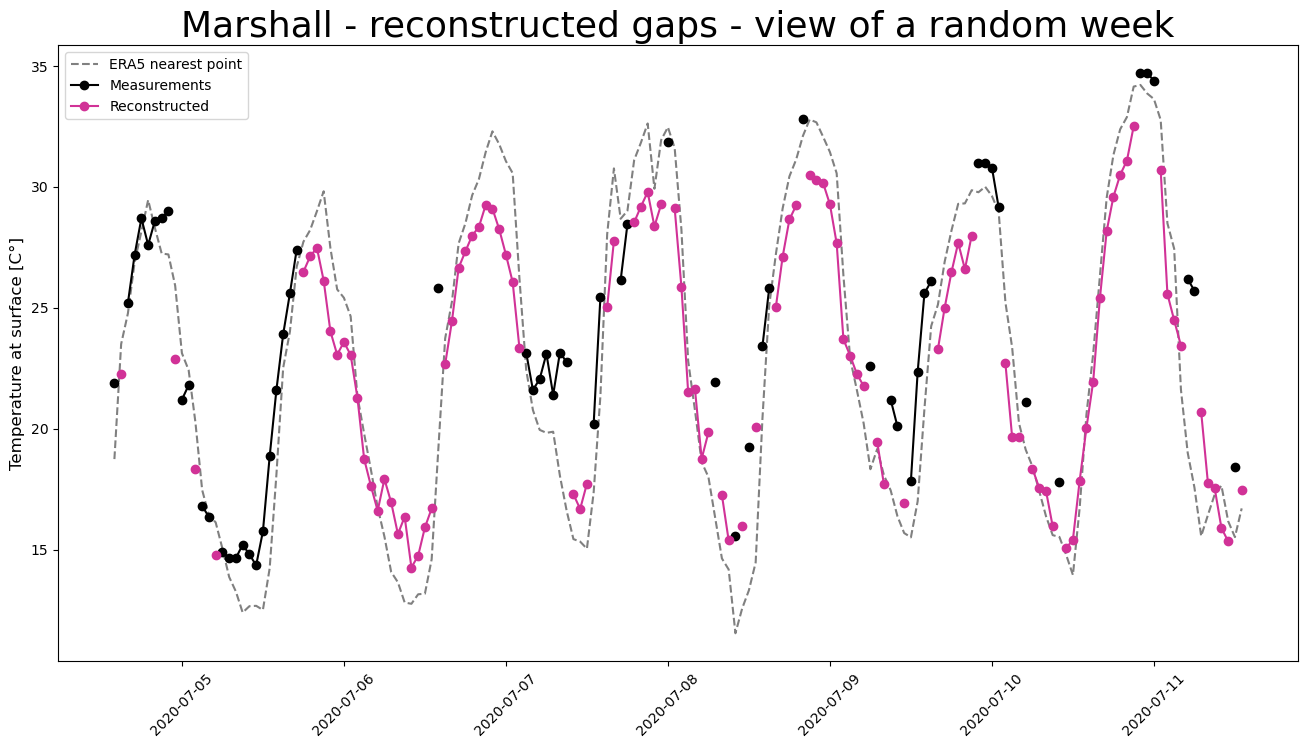

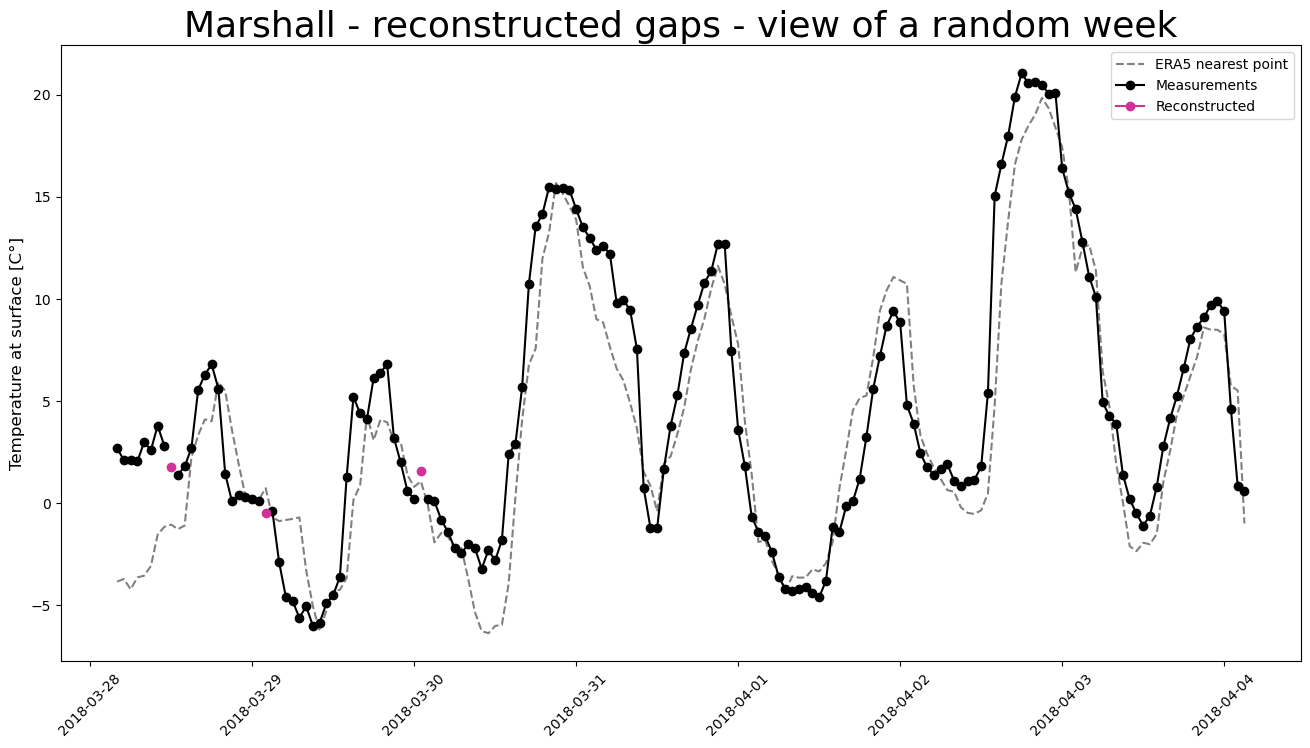

In [ ]:
for i in range(10):
    plot_n_steps_of_filled_in_df(hourly_filled_gaps_df, n=168, title=f"{station_name} - reconstructed gaps - view of a random week")